Santander Customer Transaction

#Problem Statement

In this challenge, we need to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Required Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

#Load Data

In [0]:
data=pd.read_csv("/content/drive/My Drive/train.csv")
final_test=pd.read_csv("/content/drive/My Drive/test.csv")

In [0]:
data.head()

ID_code  target    var_0   var_1  ...  var_196  var_197  var_198  var_199
0  train_0       0   8.9255 -6.7863  ...   7.8784   8.5635  12.7803  -1.0914
1  train_1       0  11.5006 -4.1473  ...   8.1267   8.7889  18.3560   1.9518
2  train_2       0   8.6093 -2.7457  ...  -6.5213   8.2675  14.7222   0.3965
3  train_3       0  11.0604 -2.1518  ...  -2.9275  10.2922  17.9697  -8.9996
4  train_4       0   9.8369 -1.4834  ...   3.9267   9.5031  17.9974  -8.8104

[5 rows x 202 columns]

# EXPLORATORY DATA ANALYSIS

In [0]:
data['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

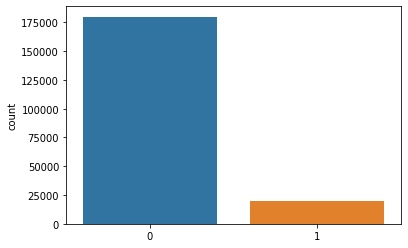

In [0]:
sns.countplot(data.target.values)

In the target there are two classes (0,1). The data belongs to class 0 count is too large than class 1. From this we consider data is imbalanced data

In [0]:
data.isna().sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

In [0]:
data.isna().sum().sum()

0

From the analysis in the data there are no null values

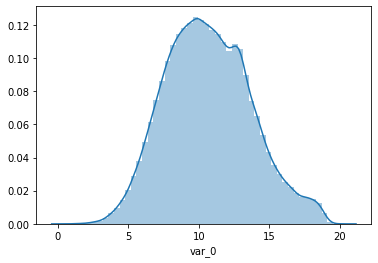

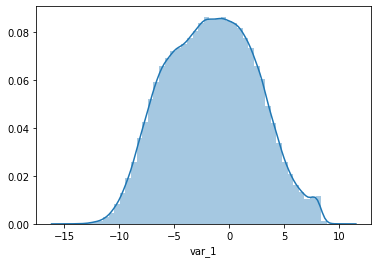

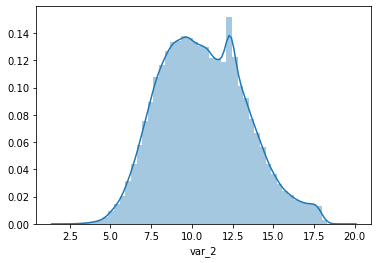

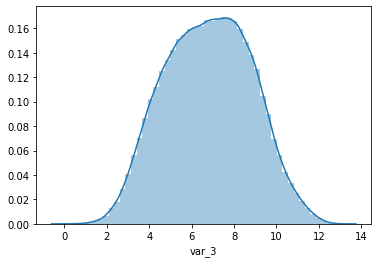

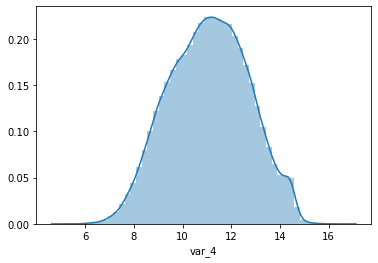

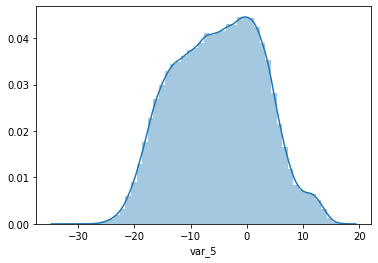

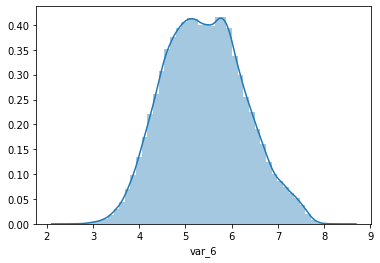

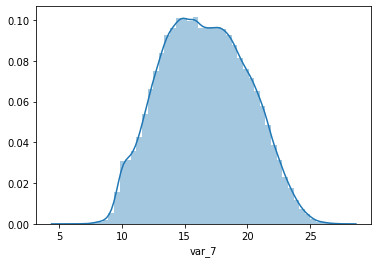

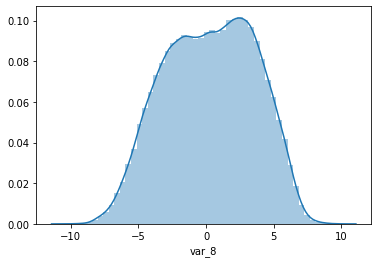

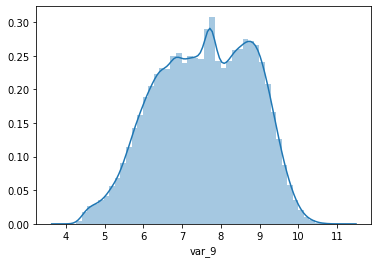

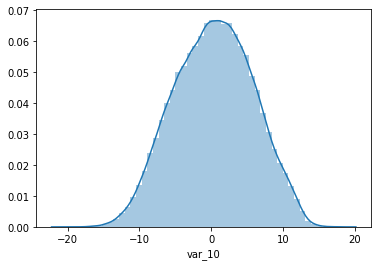

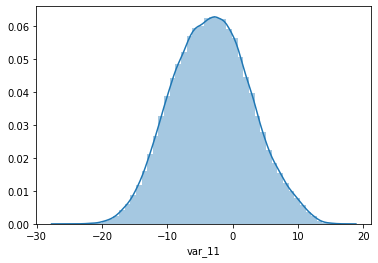

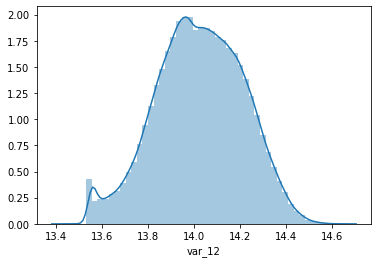

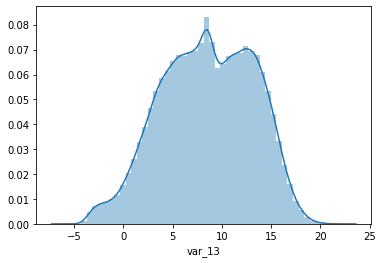

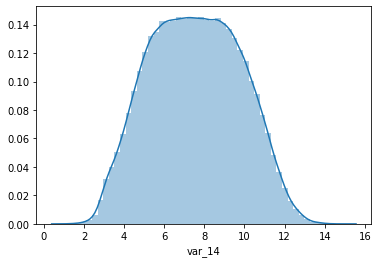

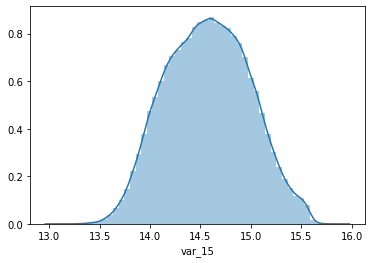

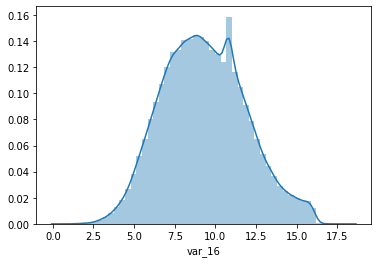

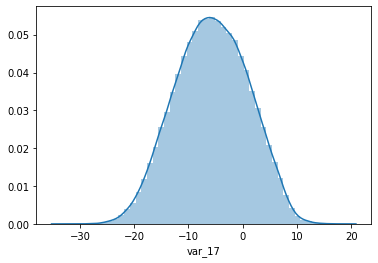

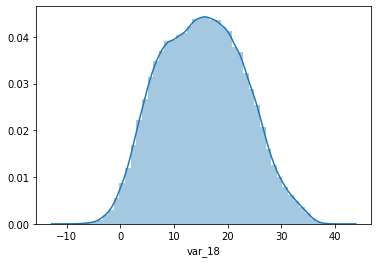

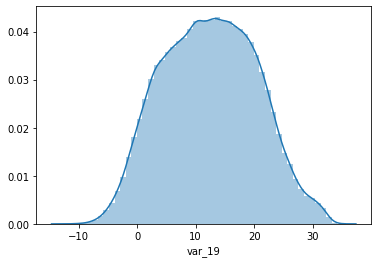

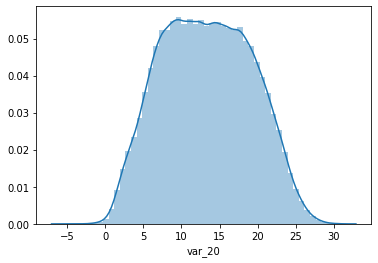

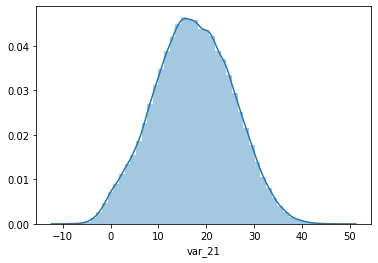

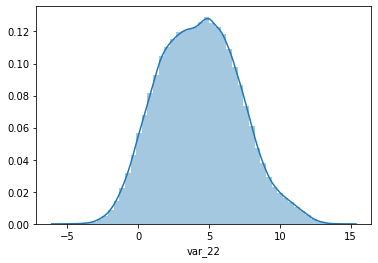

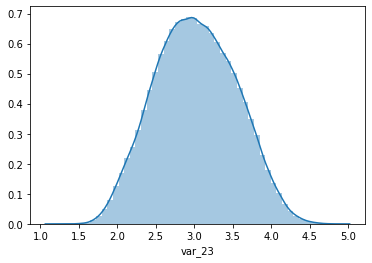

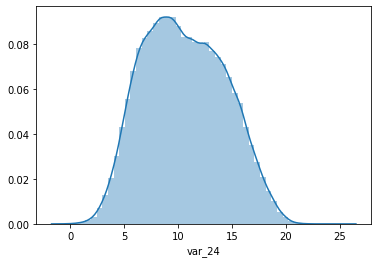

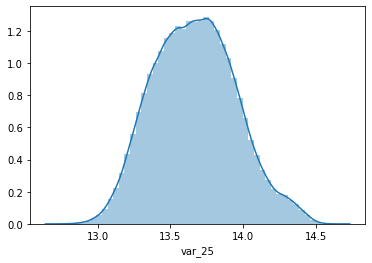

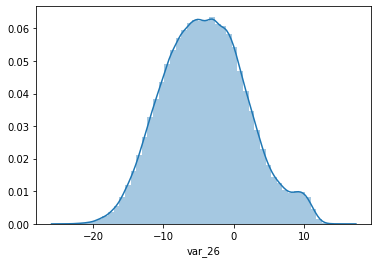

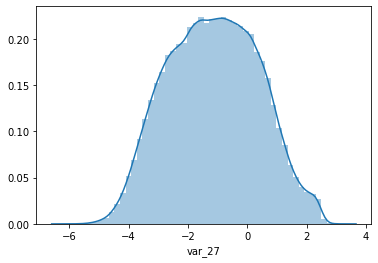

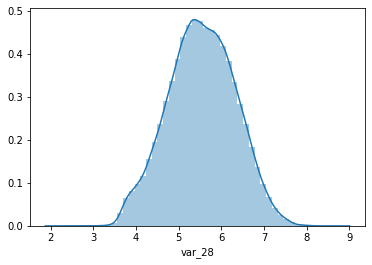

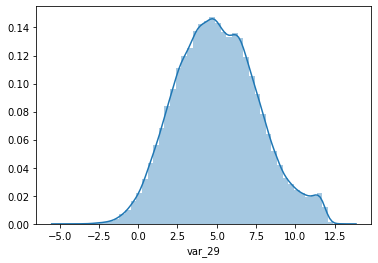

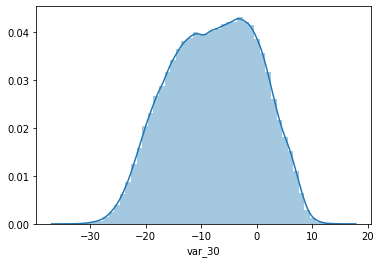

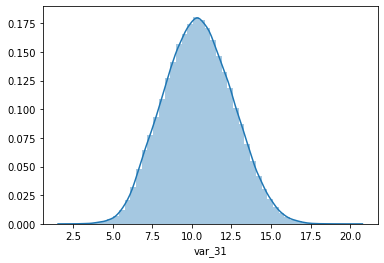

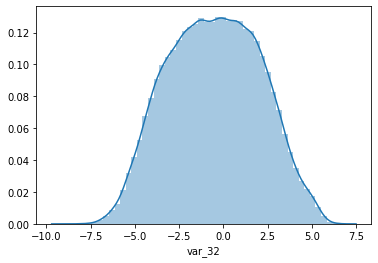

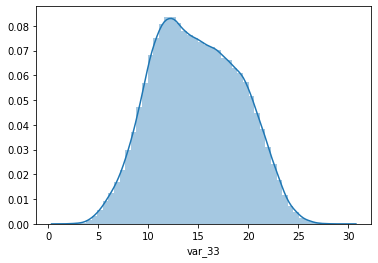

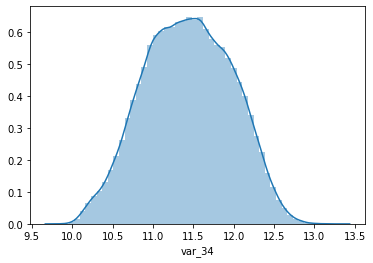

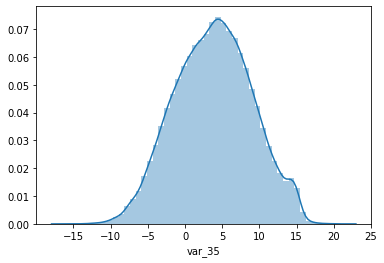

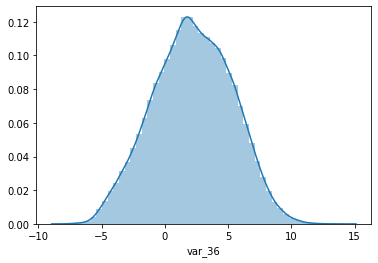

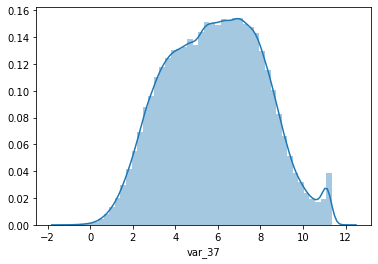

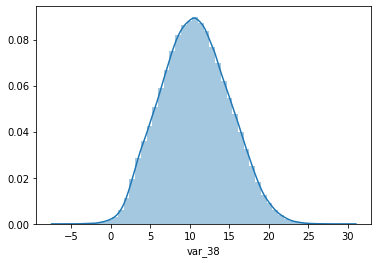

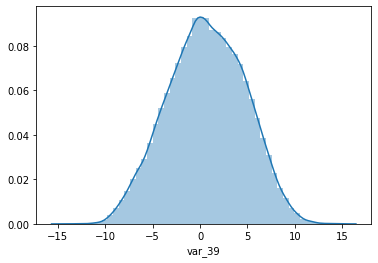

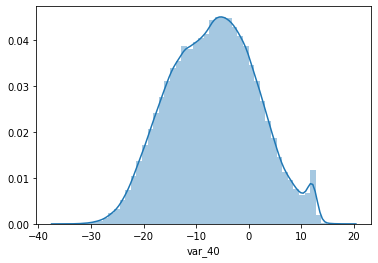

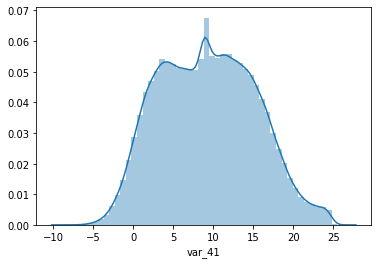

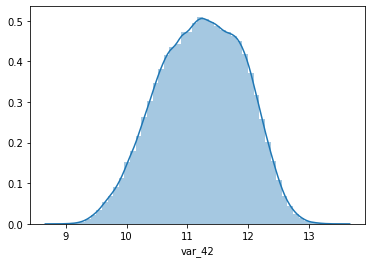

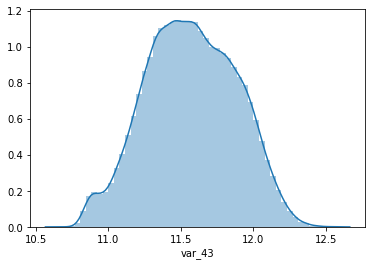

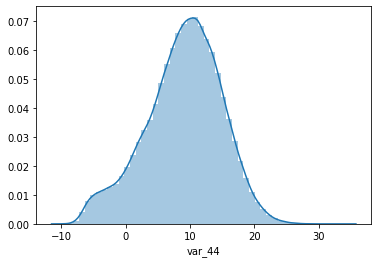

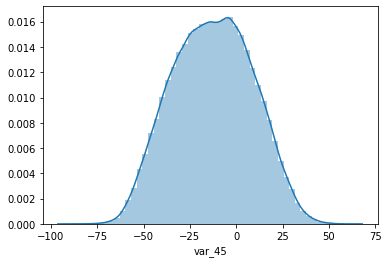

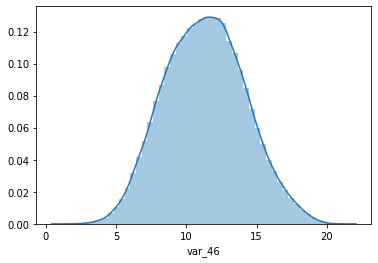

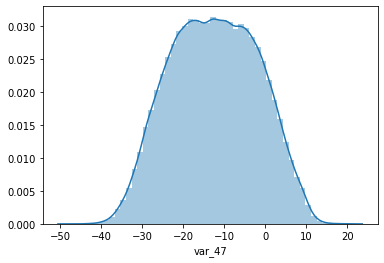

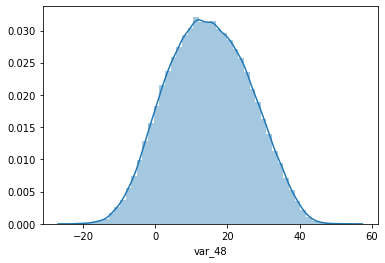

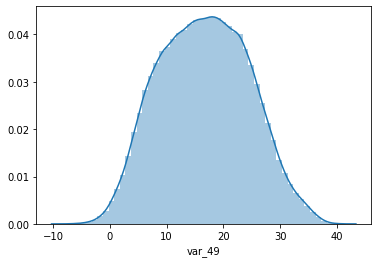

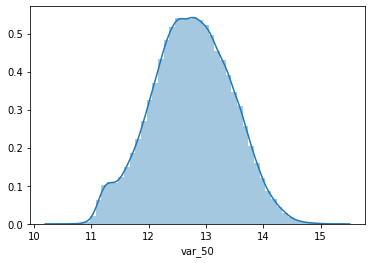

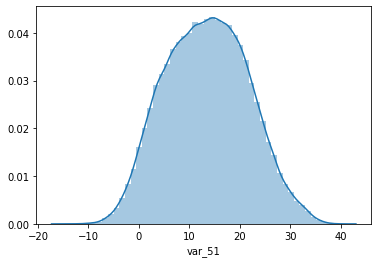

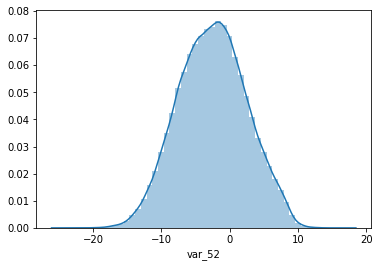

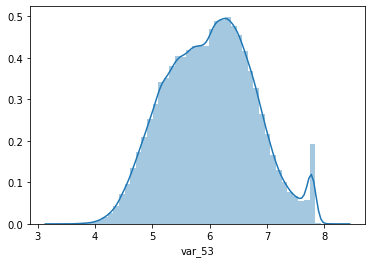

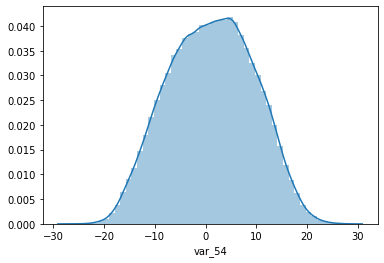

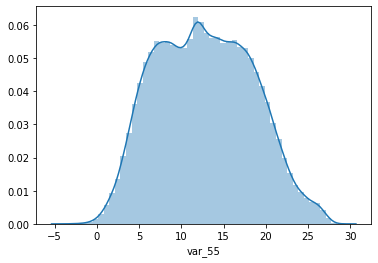

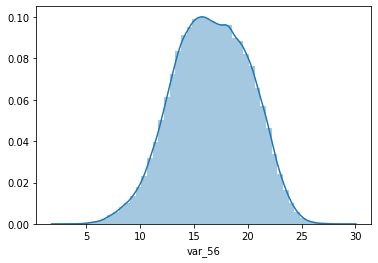

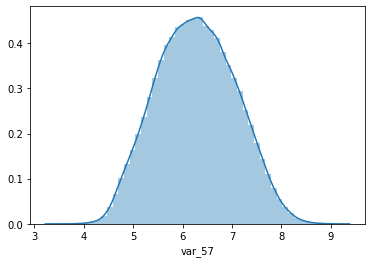

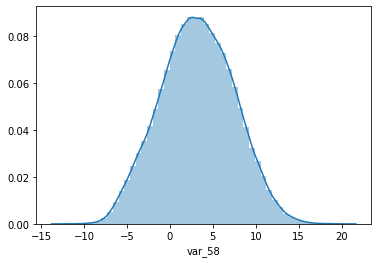

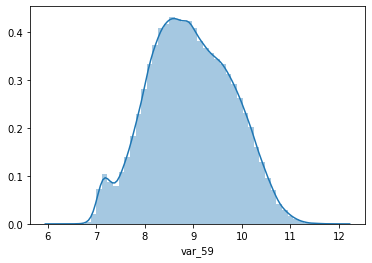

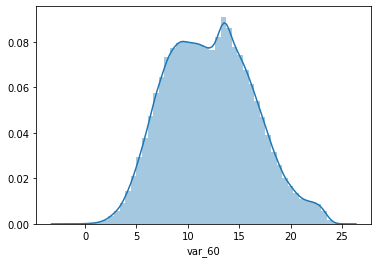

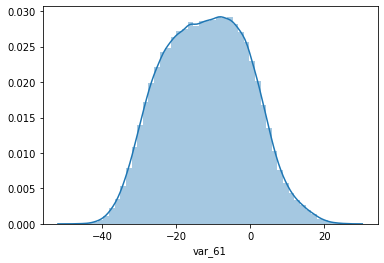

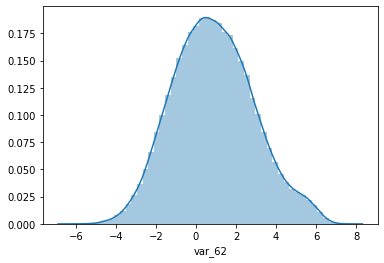

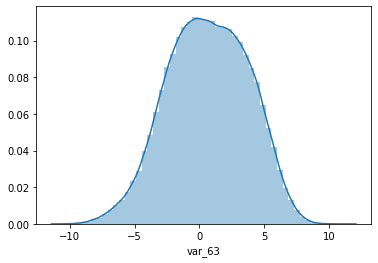

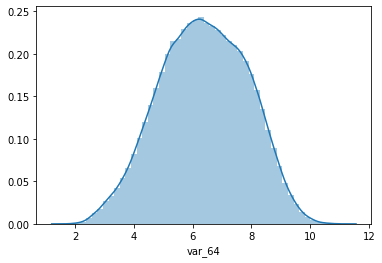

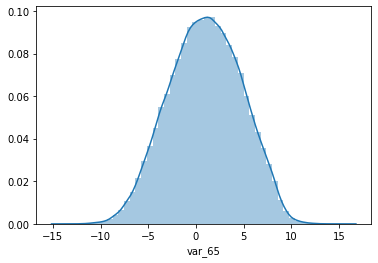

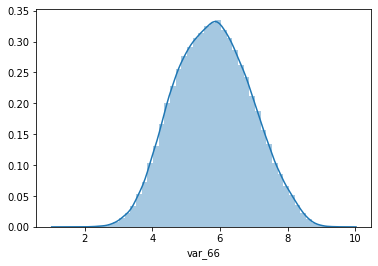

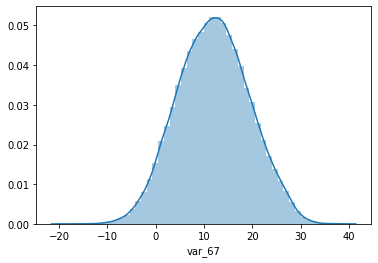

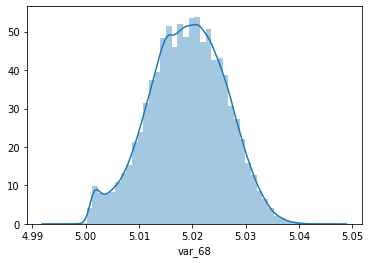

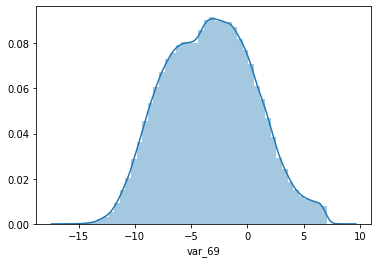

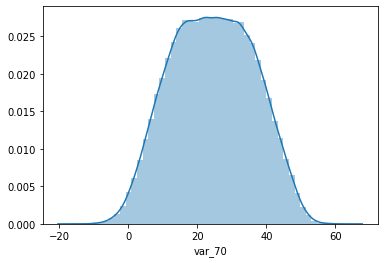

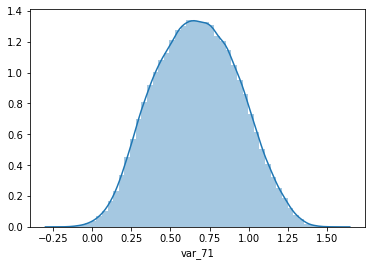

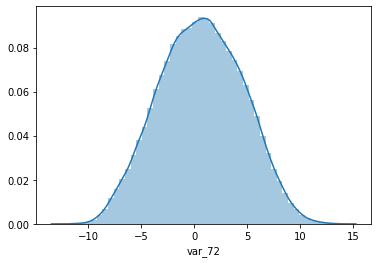

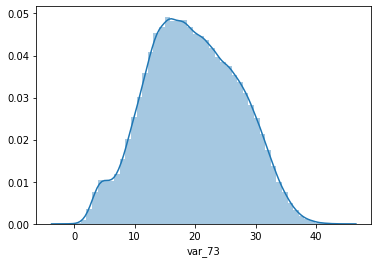

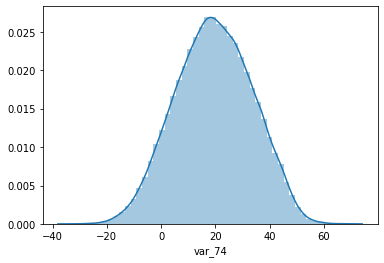

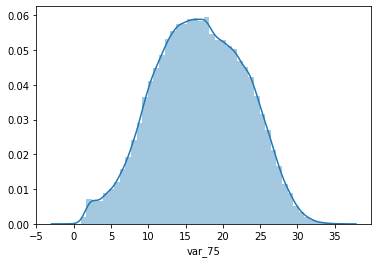

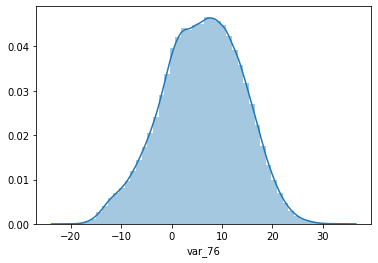

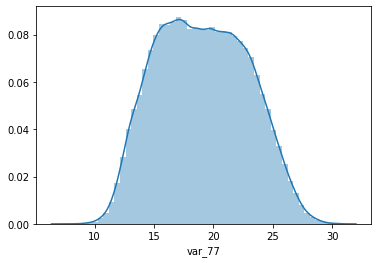

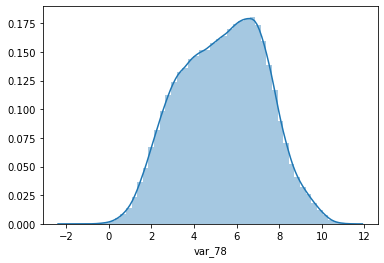

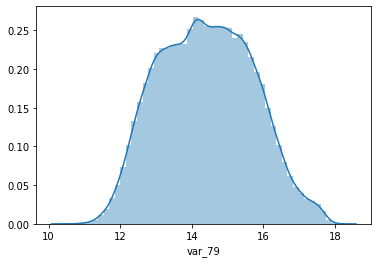

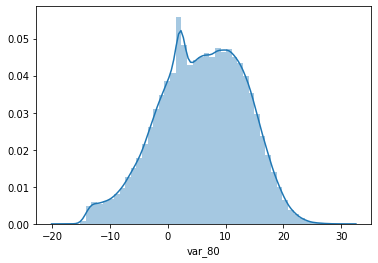

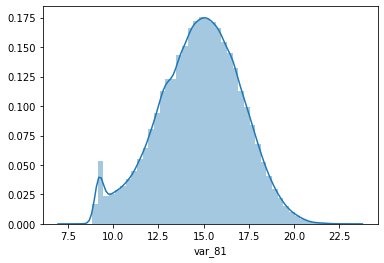

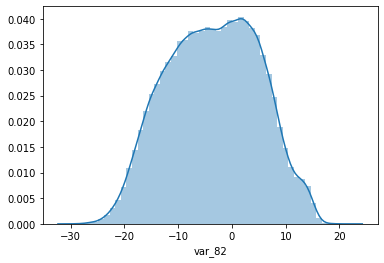

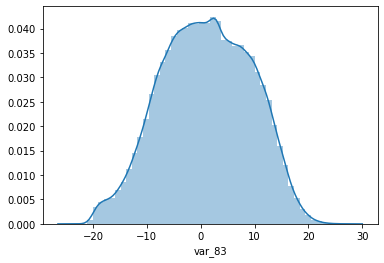

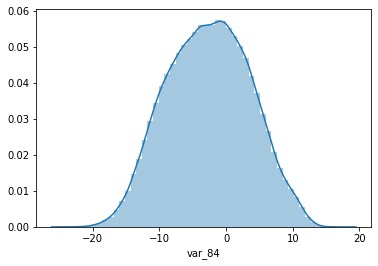

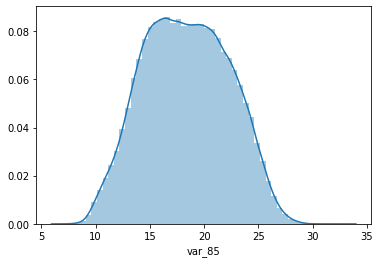

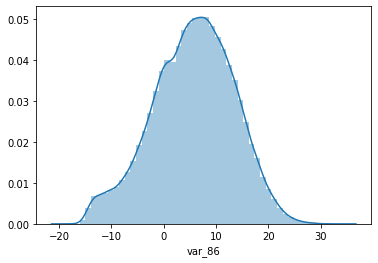

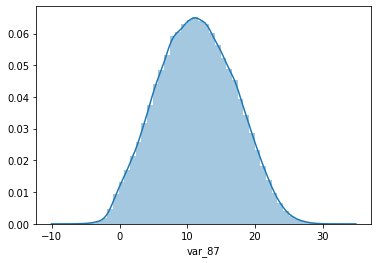

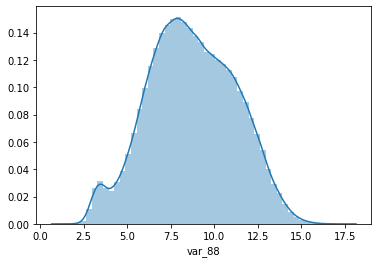

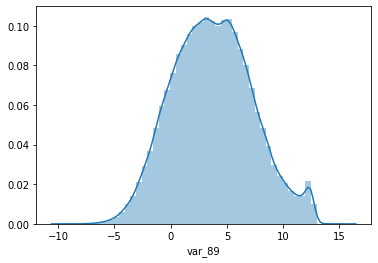

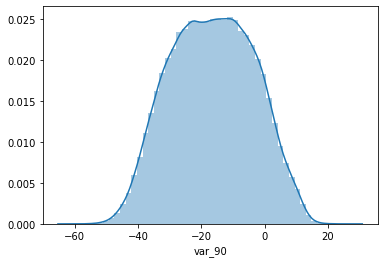

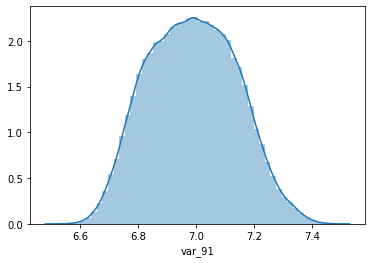

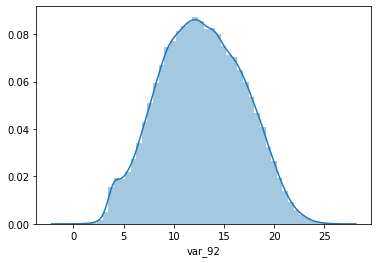

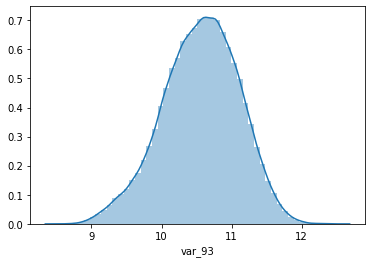

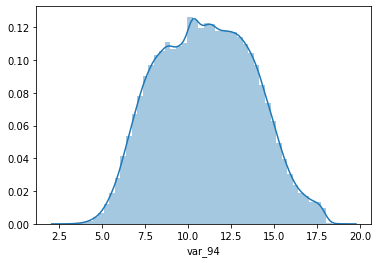

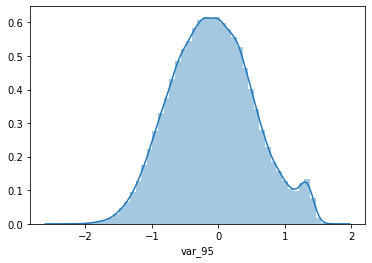

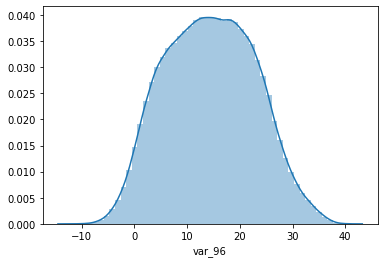

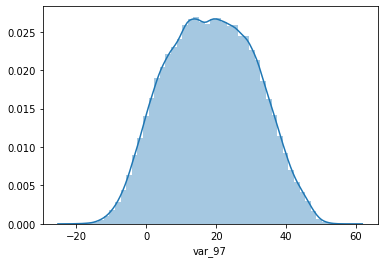

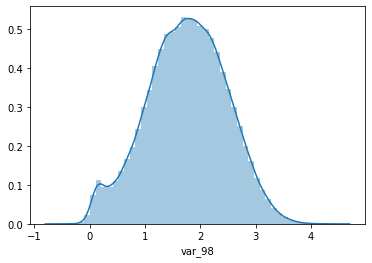

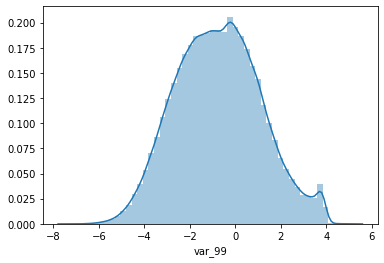

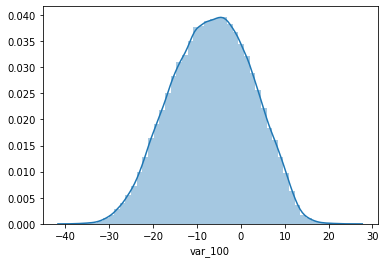

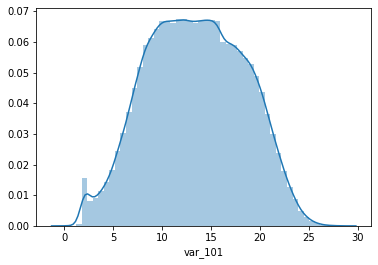

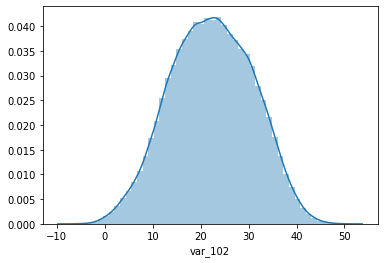

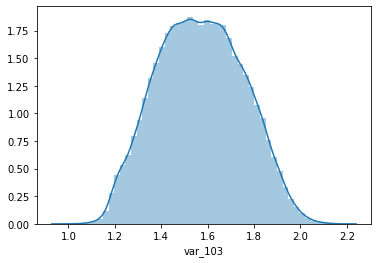

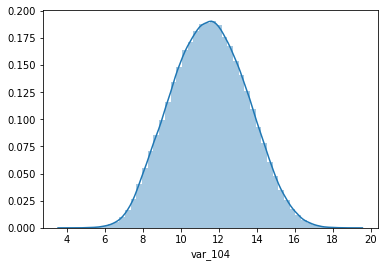

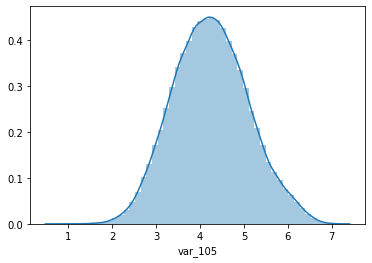

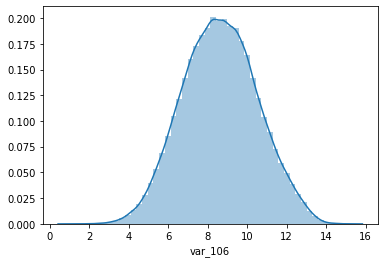

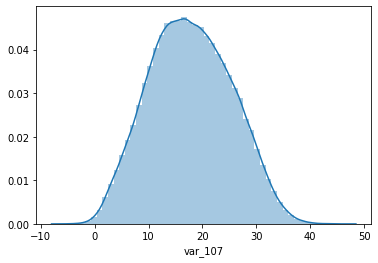

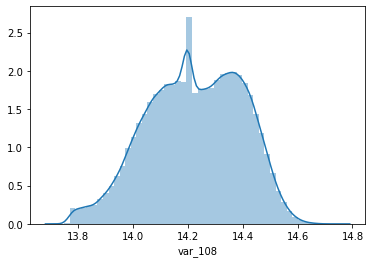

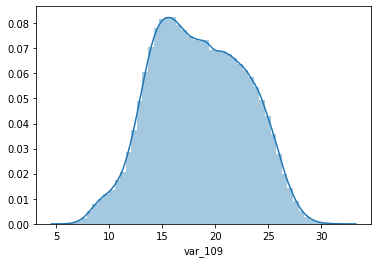

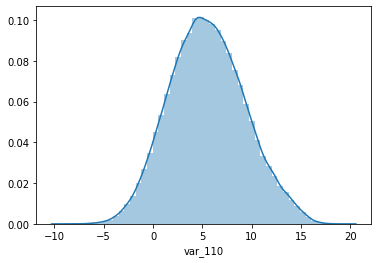

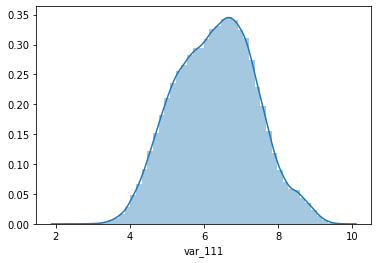

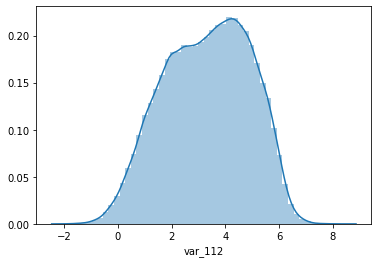

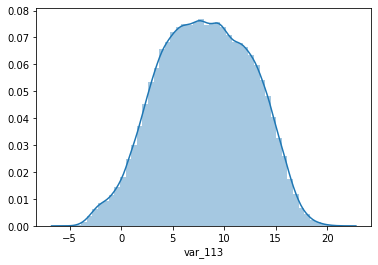

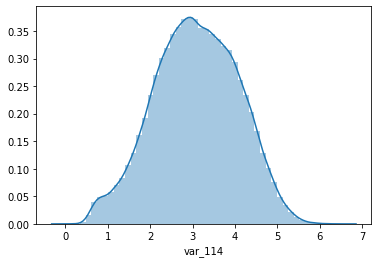

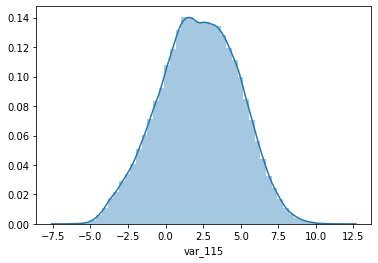

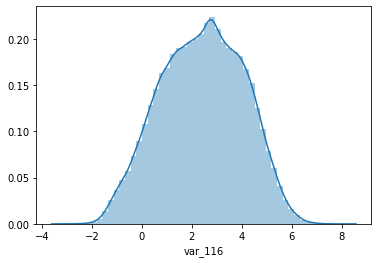

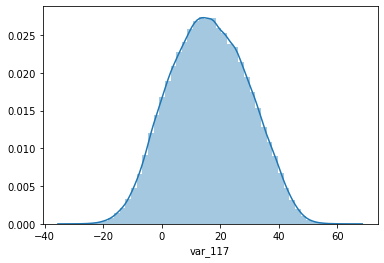

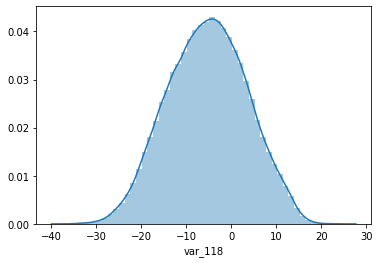

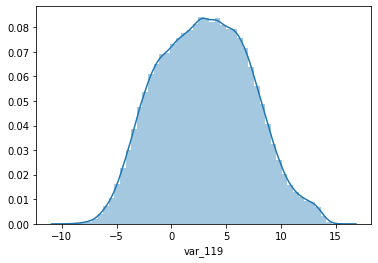

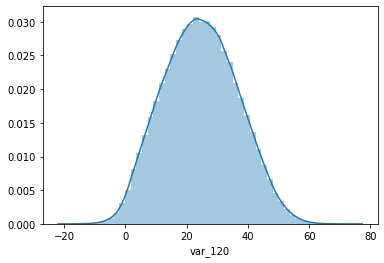

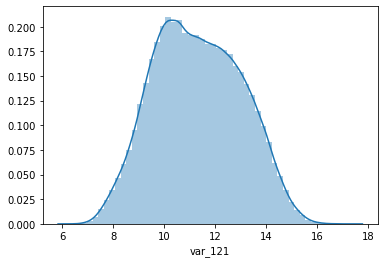

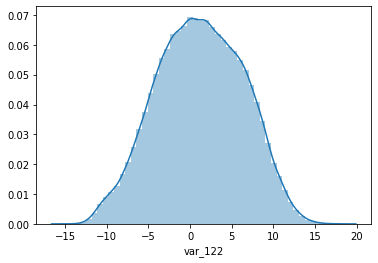

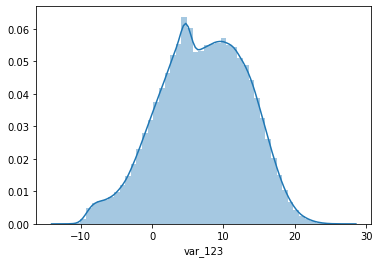

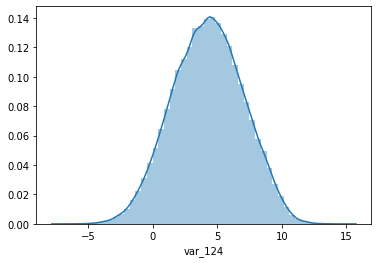

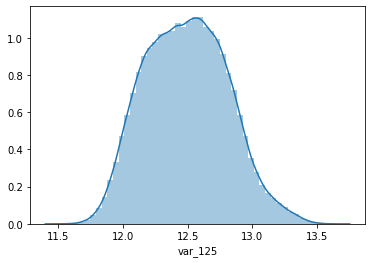

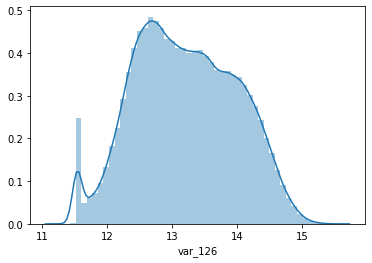

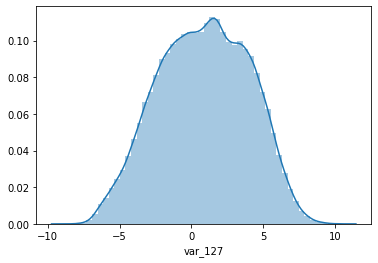

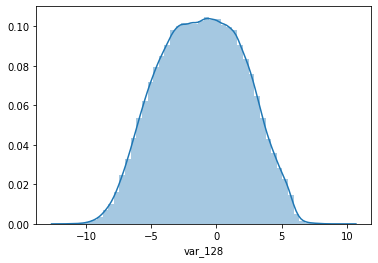

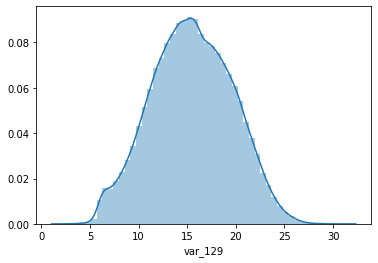

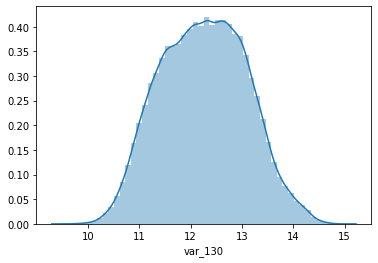

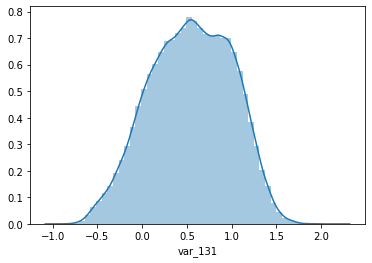

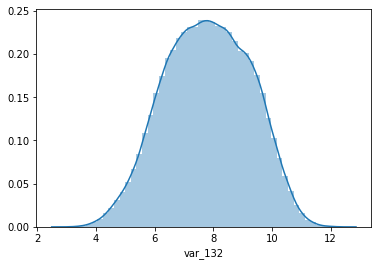

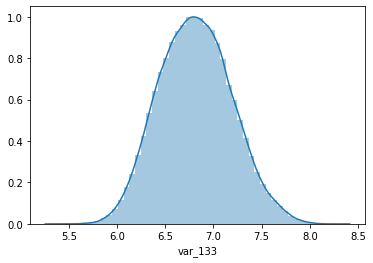

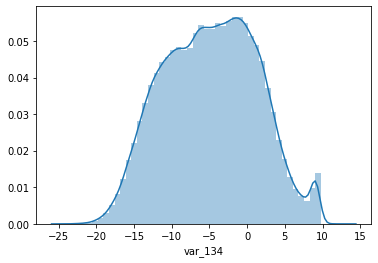

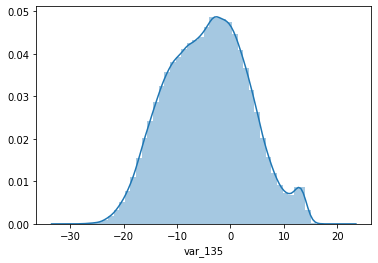

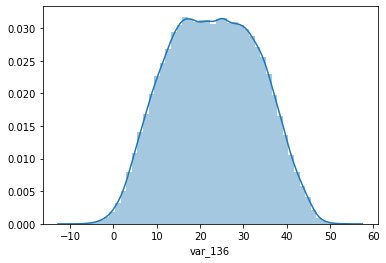

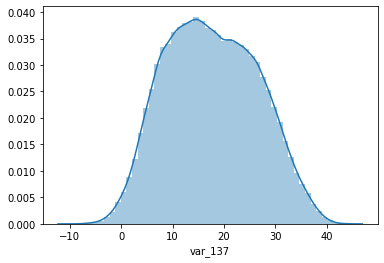

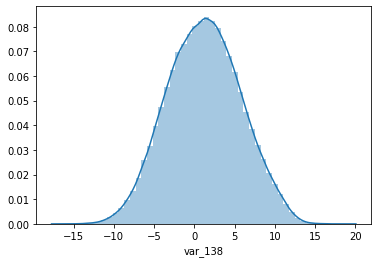

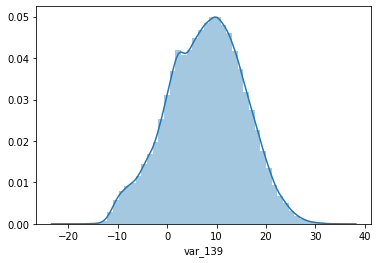

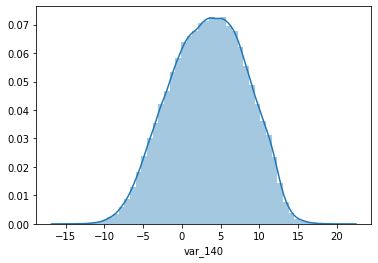

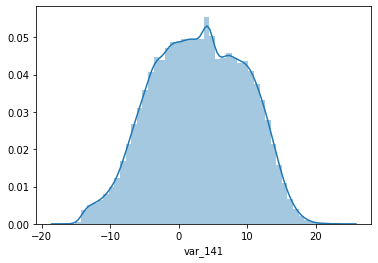

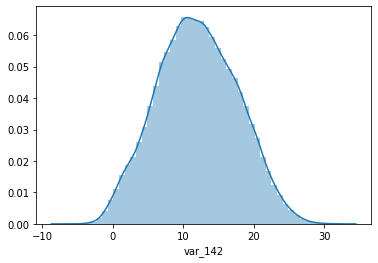

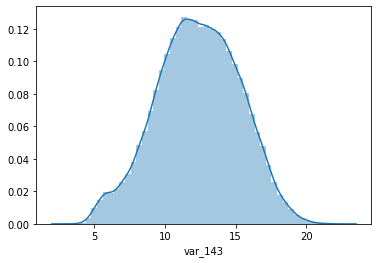

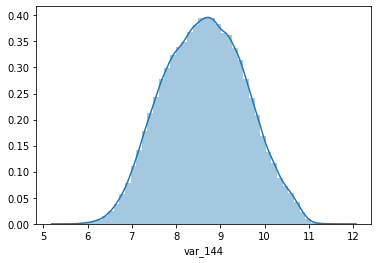

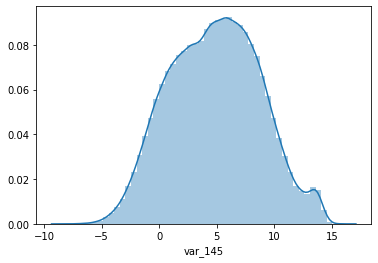

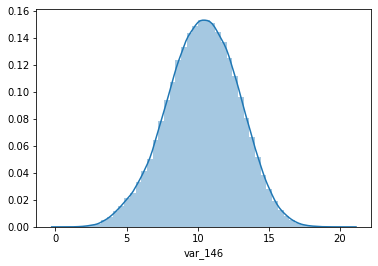

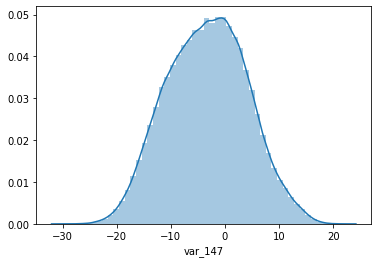

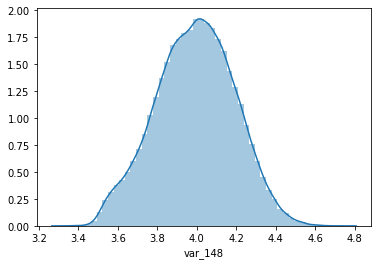

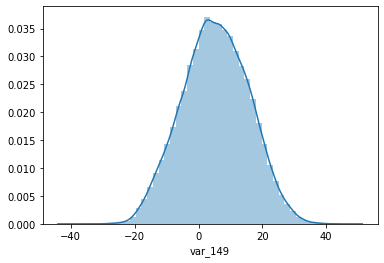

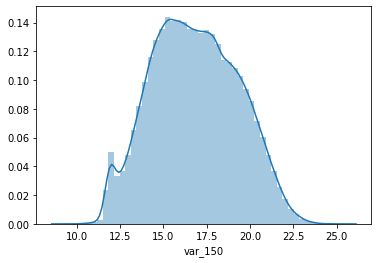

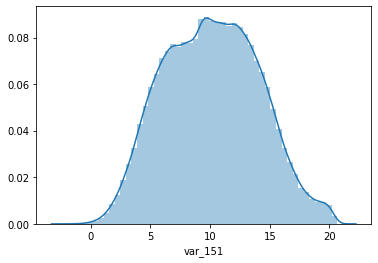

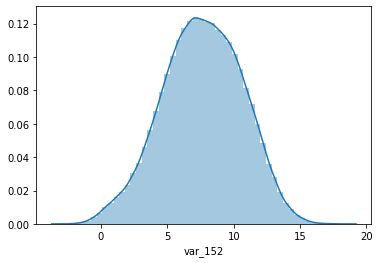

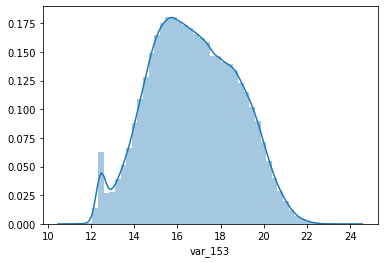

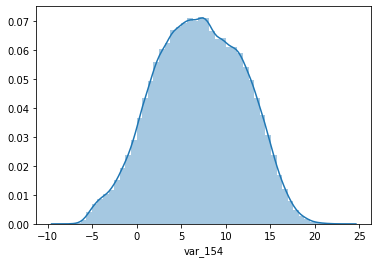

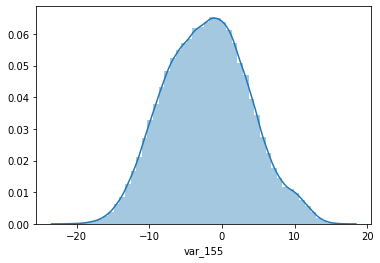

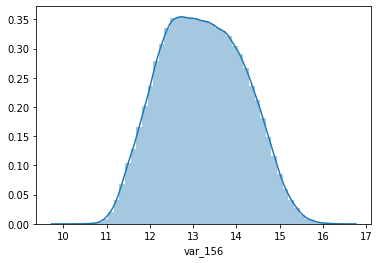

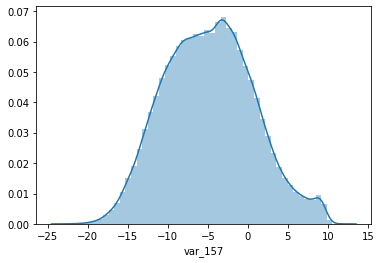

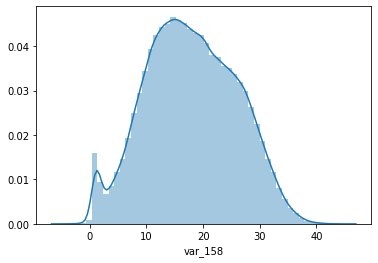

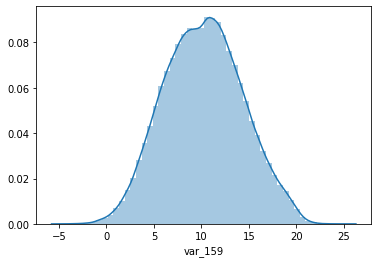

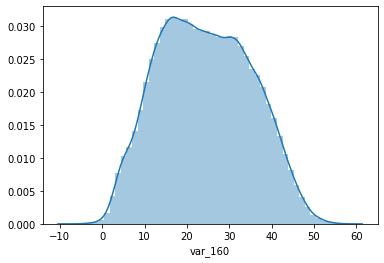

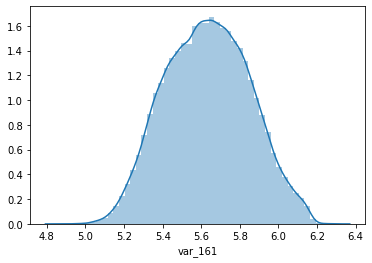

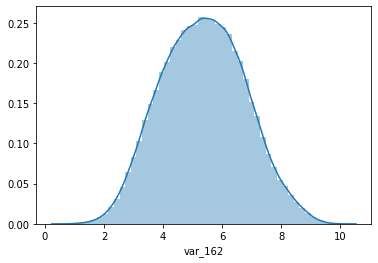

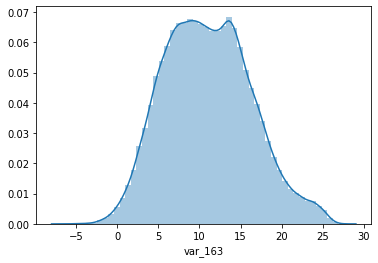

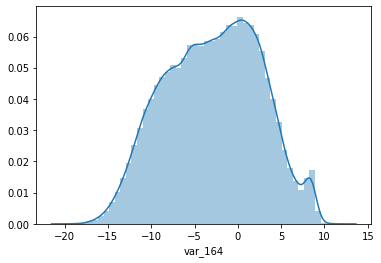

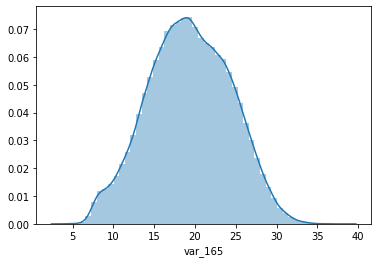

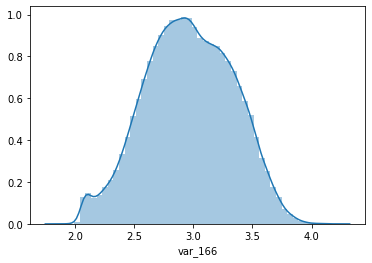

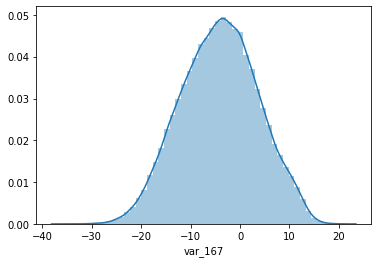

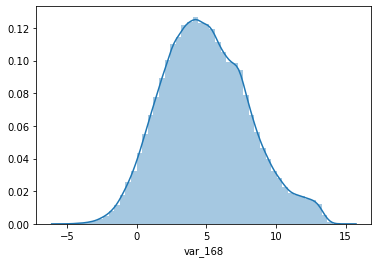

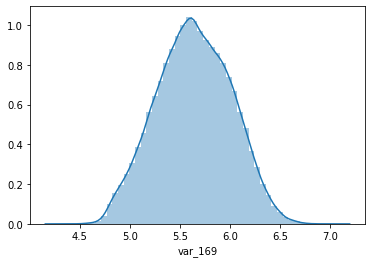

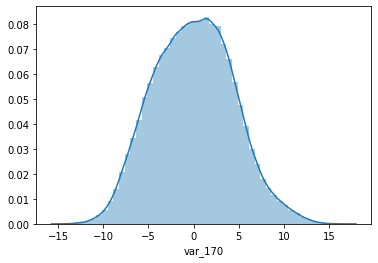

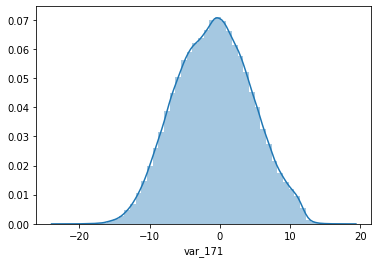

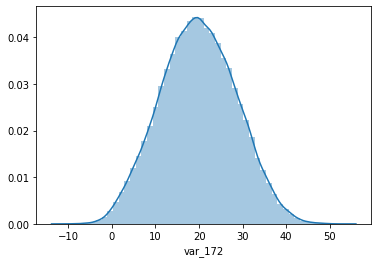

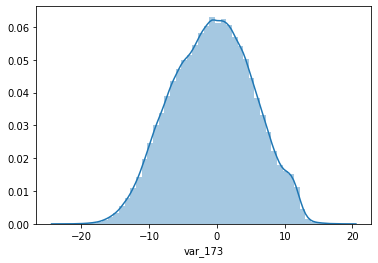

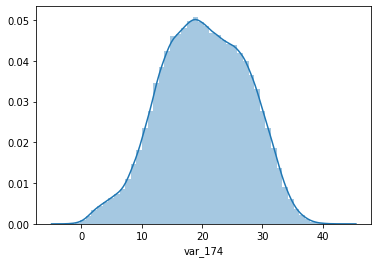

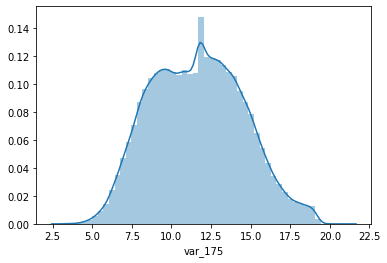

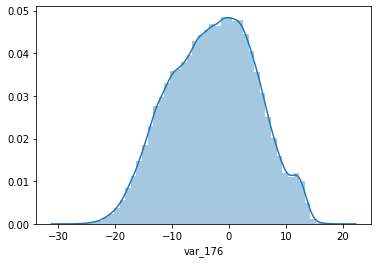

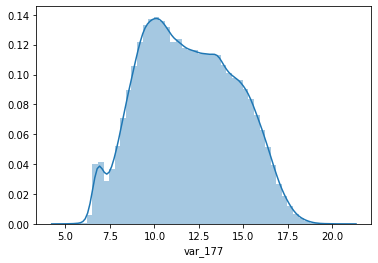

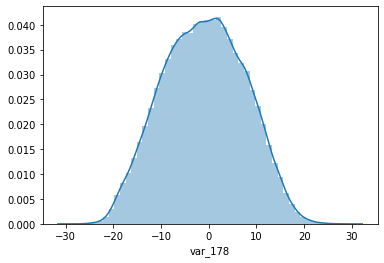

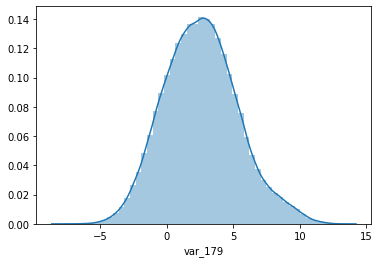

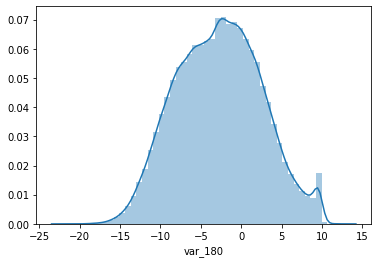

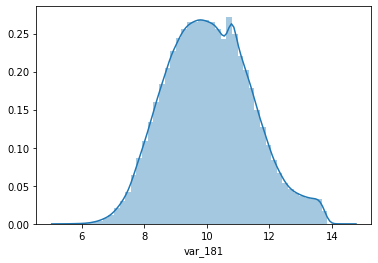

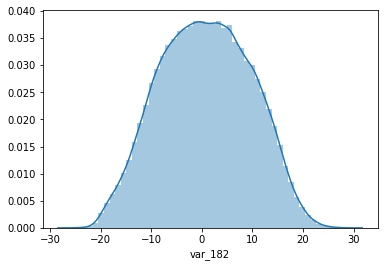

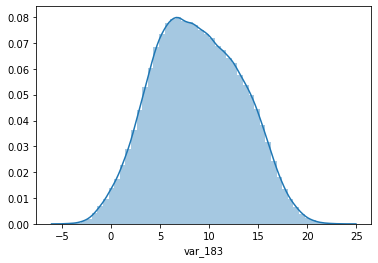

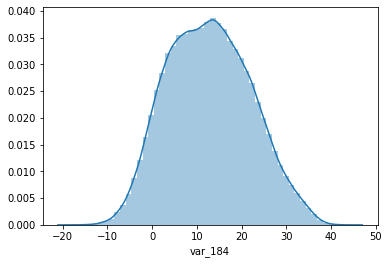

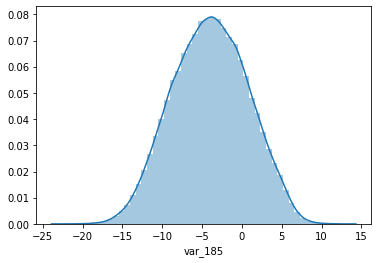

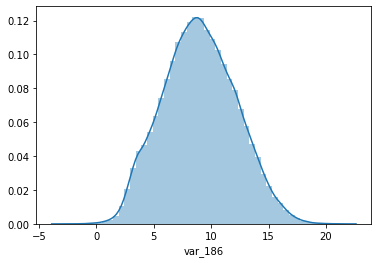

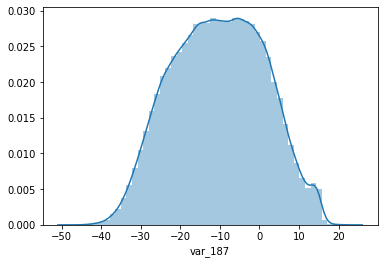

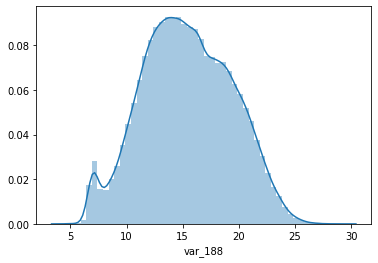

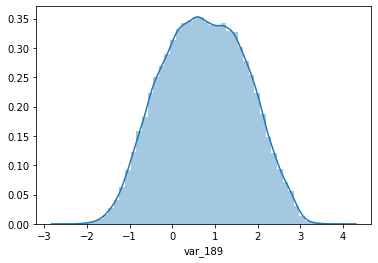

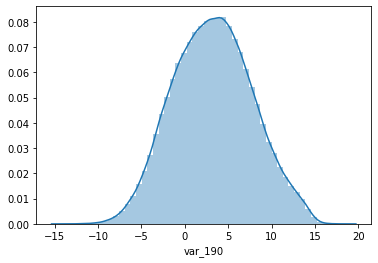

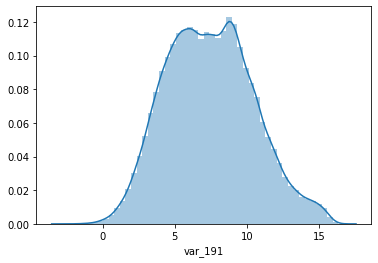

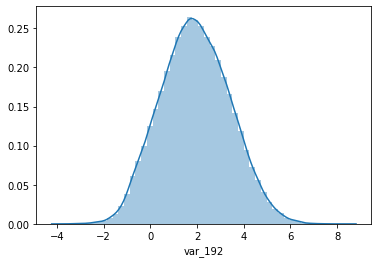

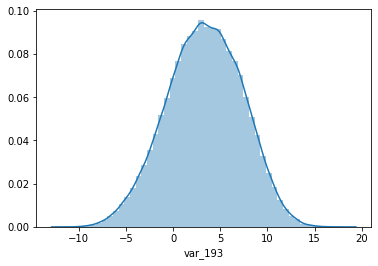

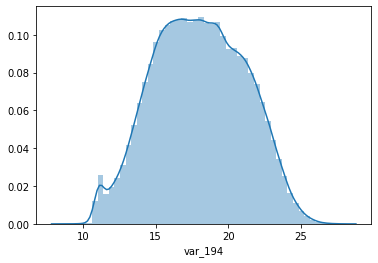

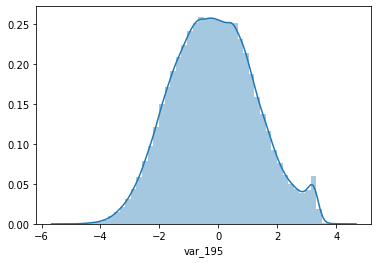

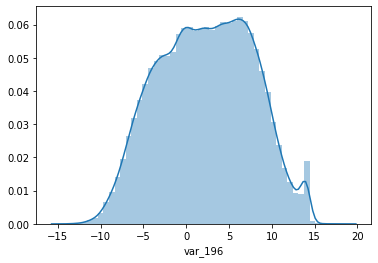

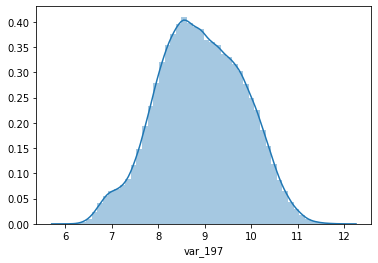

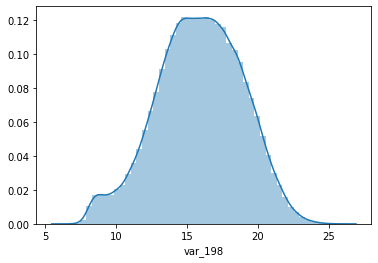

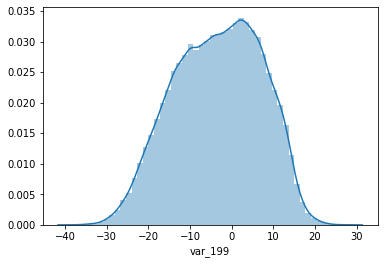

In [0]:
for i in data.columns[2:]:
  sns.distplot(data[i])
  plt.show()

On validating distribution of each variable in data the data has not much skewed,nearly symmetric about a mean

In [0]:
data.dtypes

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
            ...   
var_195    float64
var_196    float64
var_197    float64
var_198    float64
var_199    float64
Length: 202, dtype: object

In [0]:
data.describe()

target          var_0  ...        var_198        var_199
count  200000.000000  200000.000000  ...  200000.000000  200000.000000
mean        0.100490      10.679914  ...      15.870720      -3.326537
std         0.300653       3.040051  ...       3.010945      10.438015
min         0.000000       0.408400  ...       6.299300     -38.852800
25%         0.000000       8.453850  ...      13.829700     -11.208475
50%         0.000000      10.524750  ...      15.934050      -2.819550
75%         0.000000      12.758200  ...      18.064725       4.836800
max         1.000000      20.315000  ...      26.079100      28.500700

[8 rows x 201 columns]

In [0]:
data.corr()

target     var_0     var_1  ...   var_197   var_198   var_199
target   1.000000  0.052390  0.050343  ... -0.035303 -0.053000  0.025434
var_0    0.052390  1.000000 -0.000544  ... -0.000753 -0.005776  0.003850
var_1    0.050343 -0.000544  1.000000  ... -0.004157 -0.004861  0.002287
var_2    0.055870  0.006573  0.003980  ...  0.001078 -0.000877  0.003855
var_3    0.011055  0.003801  0.000010  ...  0.001164 -0.001651  0.000506
...           ...       ...       ...  ...       ...       ...       ...
var_195  0.028285  0.002073 -0.000785  ... -0.004170 -0.000536  0.002042
var_196  0.023608  0.004386 -0.000377  ... -0.000454  0.000253  0.000607
var_197 -0.035303 -0.000753 -0.004157  ...  1.000000  0.001183  0.004991
var_198 -0.053000 -0.005776 -0.004861  ...  0.001183  1.000000 -0.004731
var_199  0.025434  0.003850  0.002287  ...  0.004991 -0.004731  1.000000

[201 rows x 201 columns]

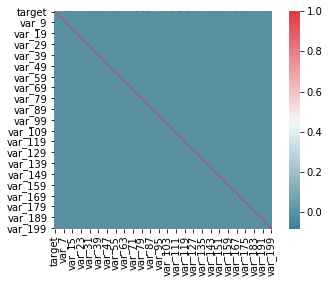

In [0]:
corr=data.corr()
f,ax=plt.subplots()
sns.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sns.diverging_palette(220,10,as_cmap=True),square=True,ax=ax)

# Outlier Analysis

It looks like there is no correlation between variables in the data 

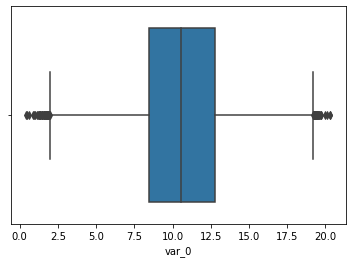

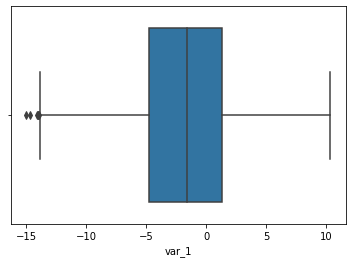

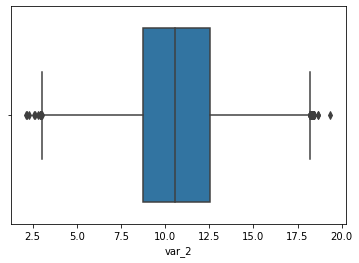

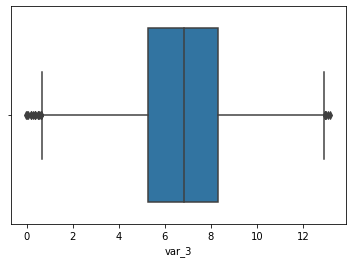

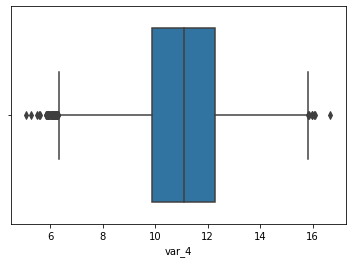

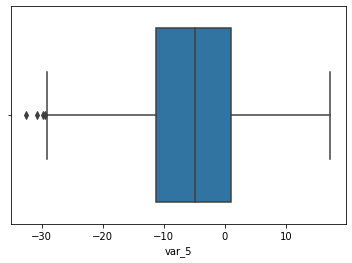

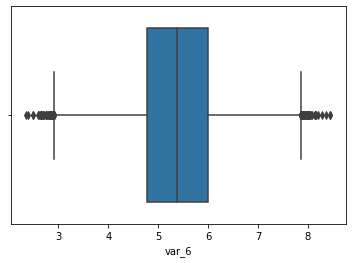

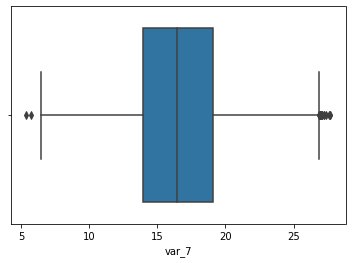

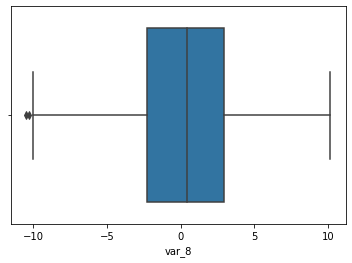

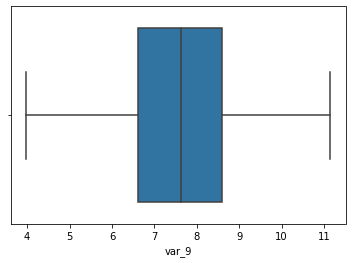

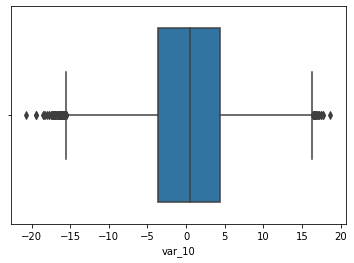

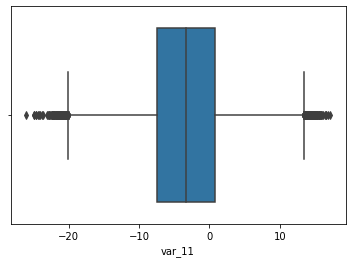

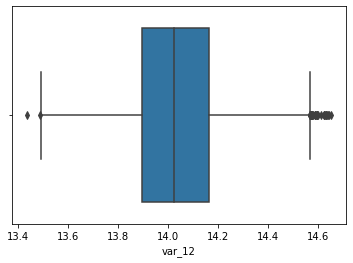

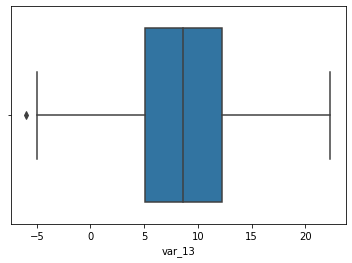

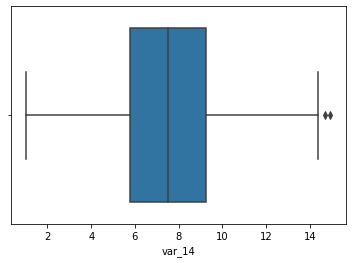

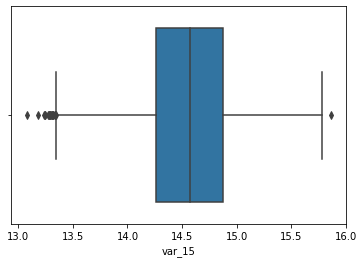

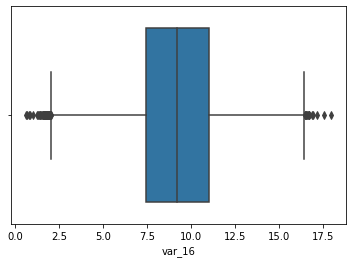

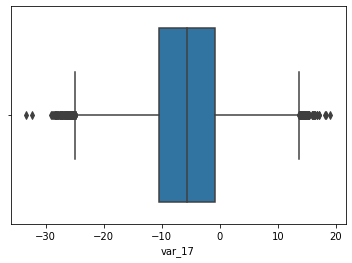

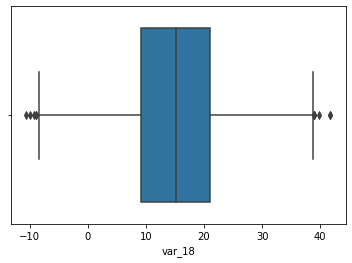

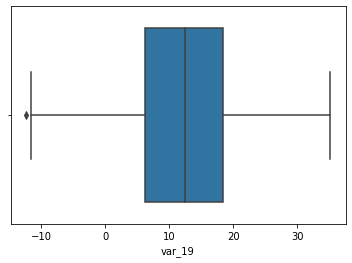

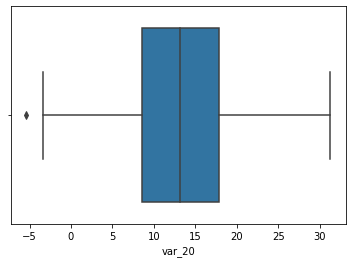

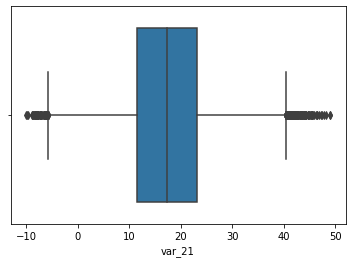

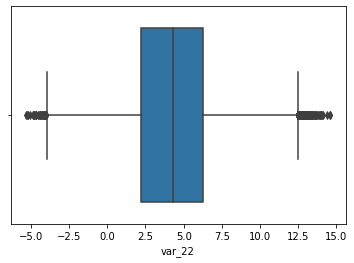

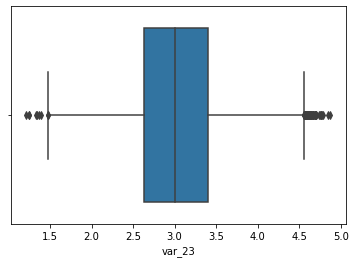

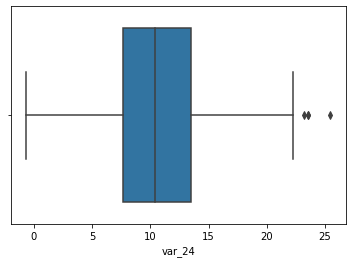

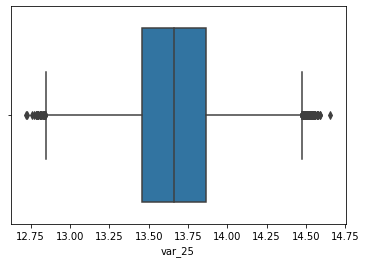

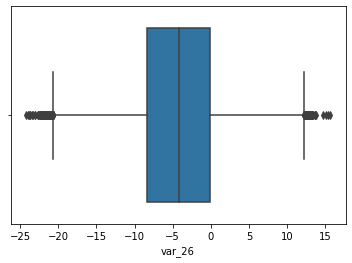

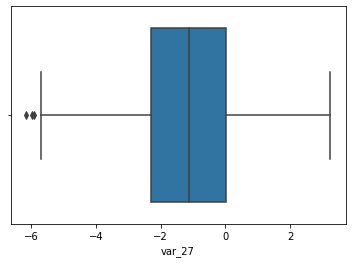

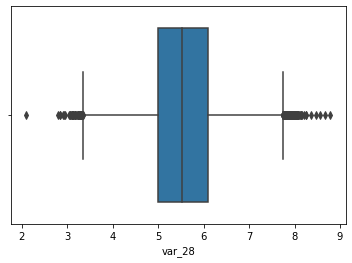

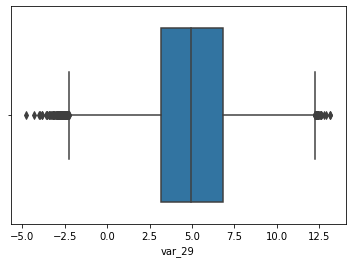

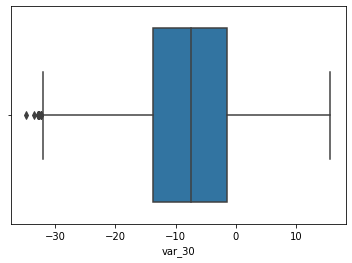

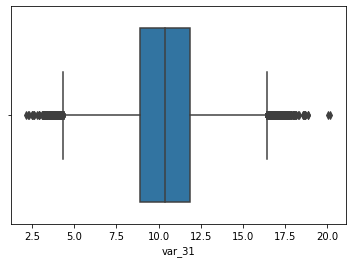

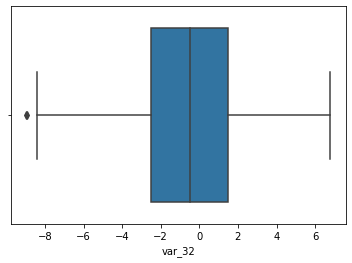

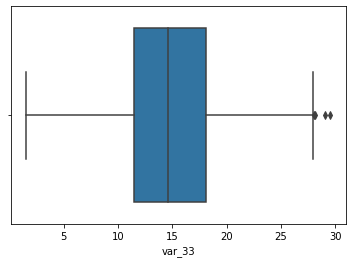

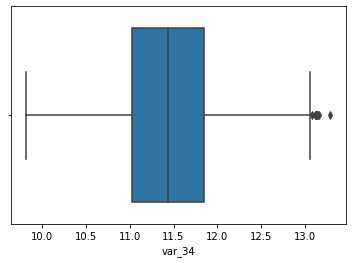

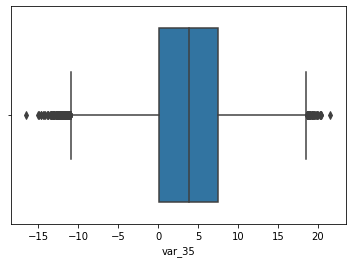

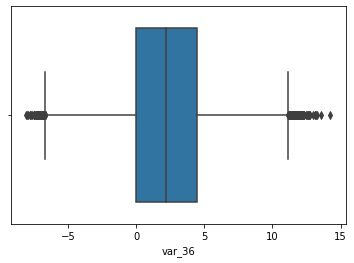

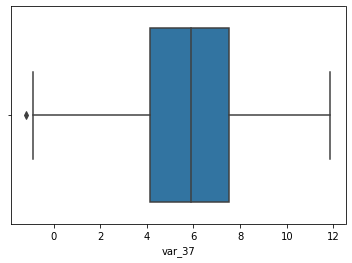

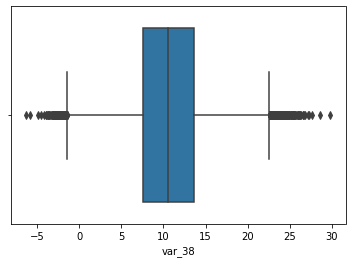

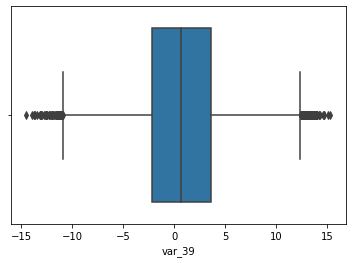

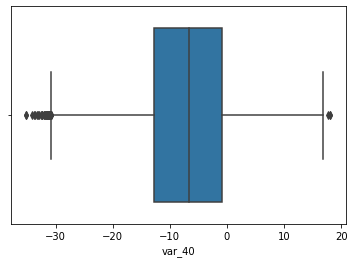

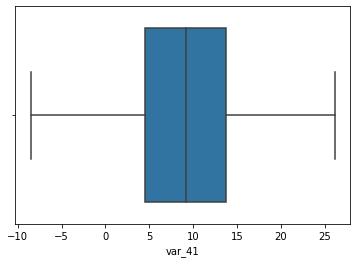

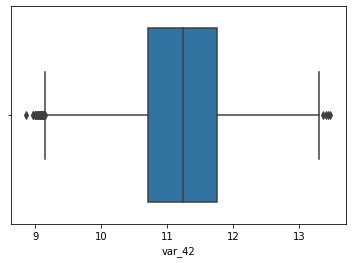

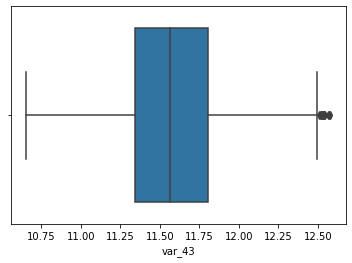

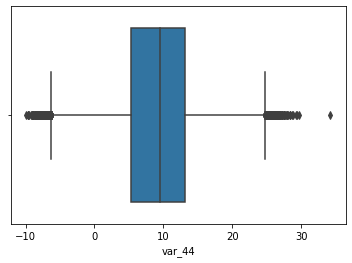

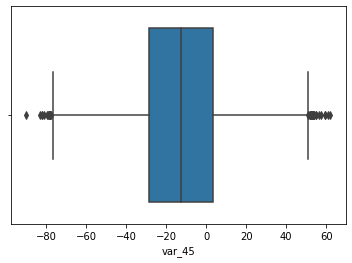

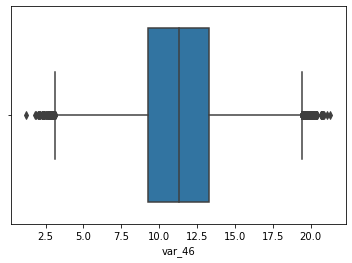

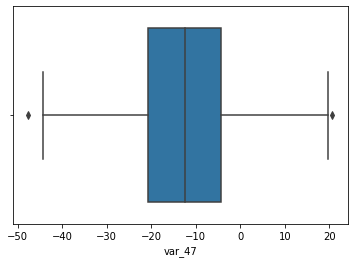

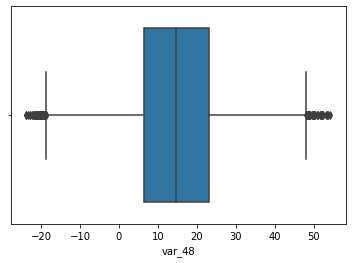

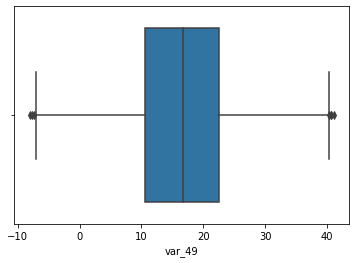

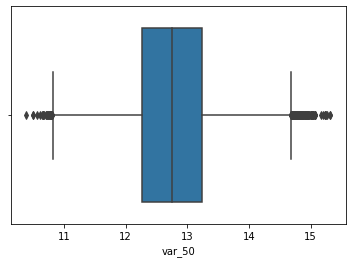

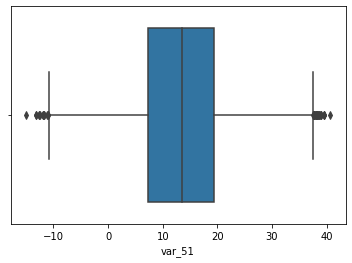

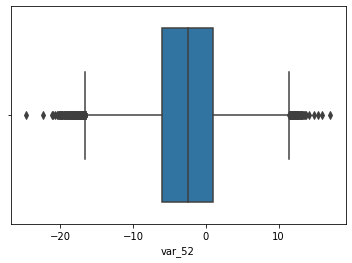

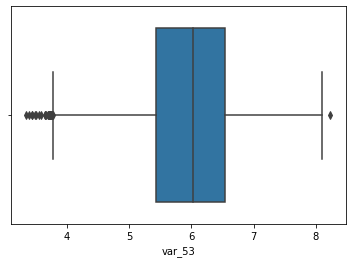

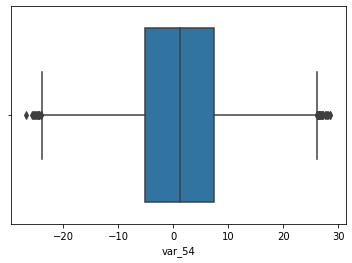

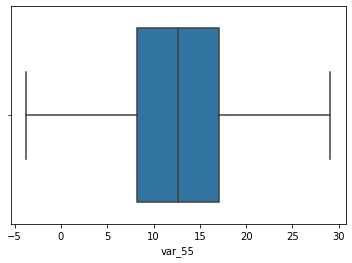

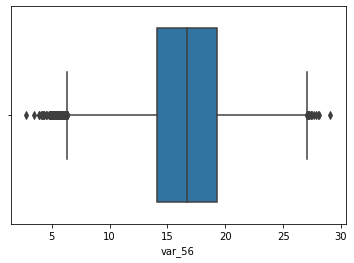

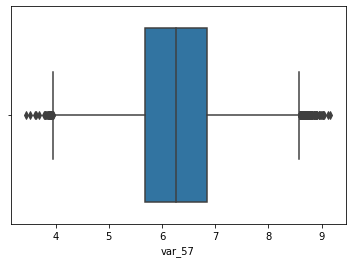

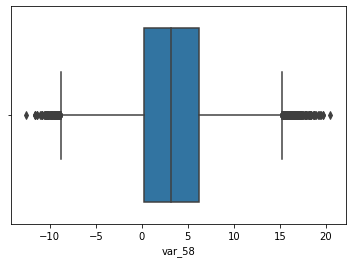

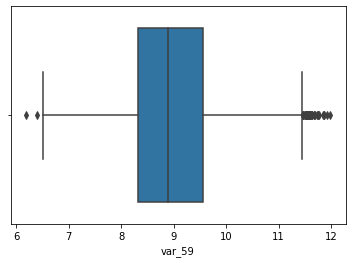

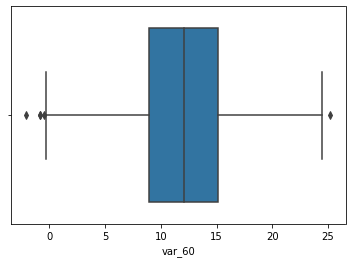

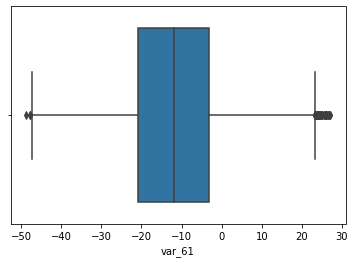

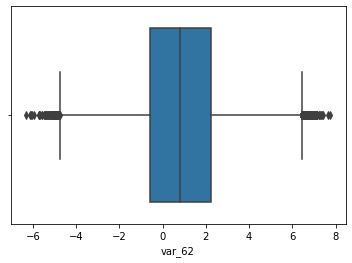

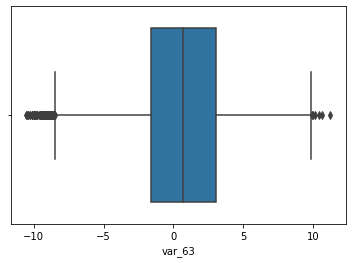

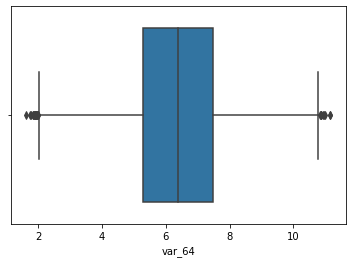

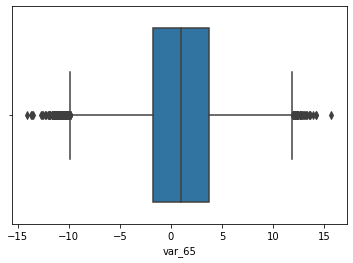

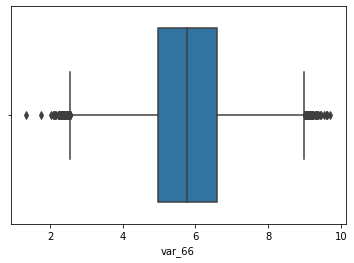

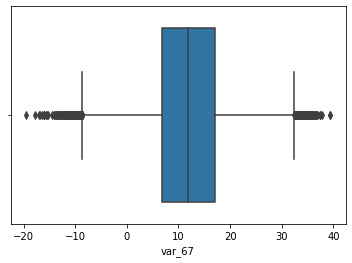

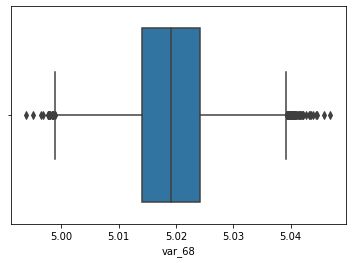

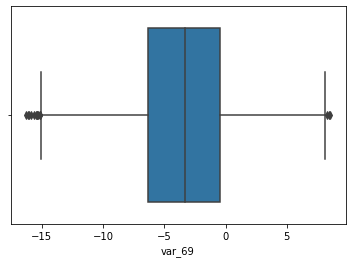

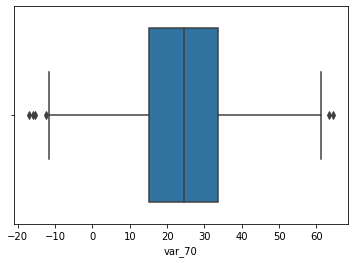

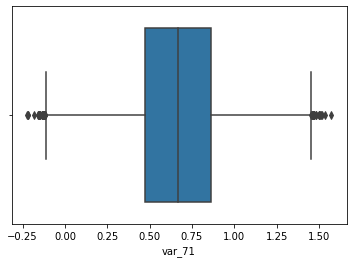

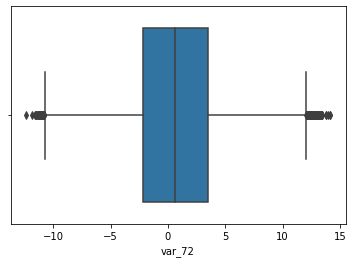

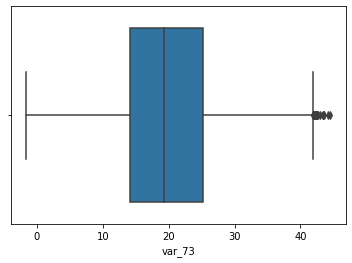

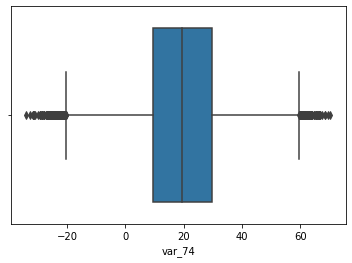

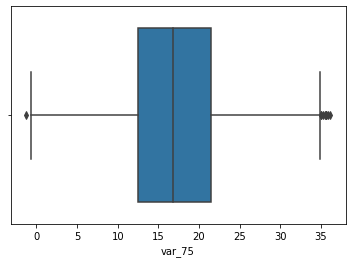

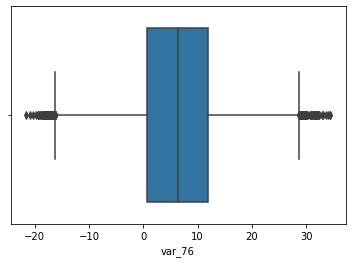

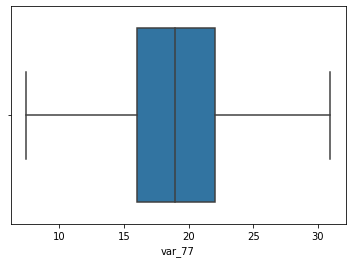

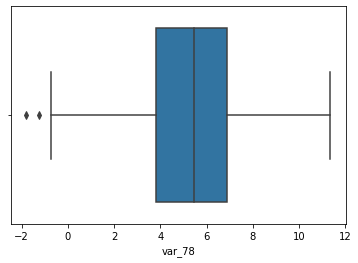

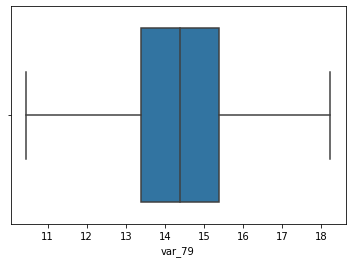

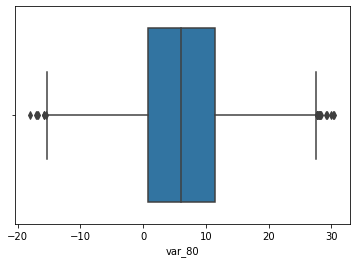

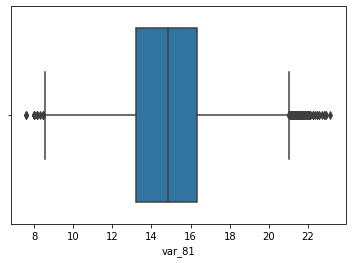

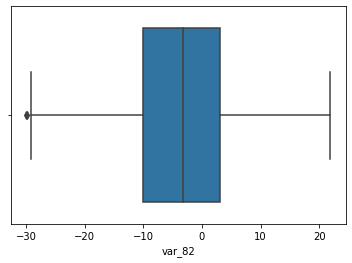

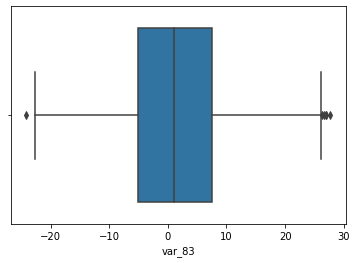

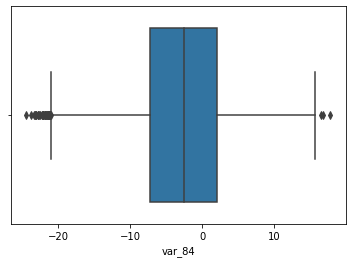

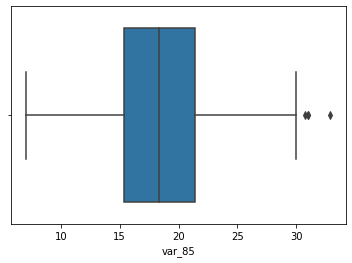

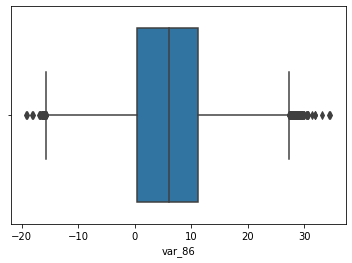

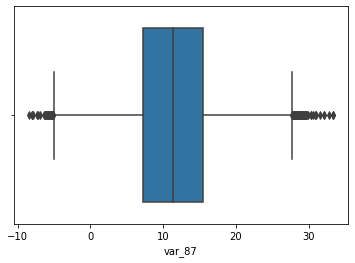

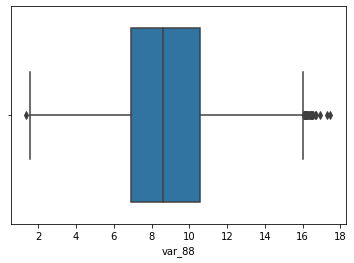

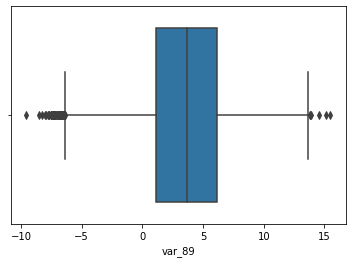

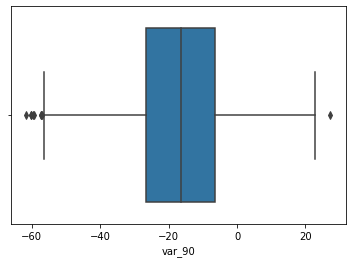

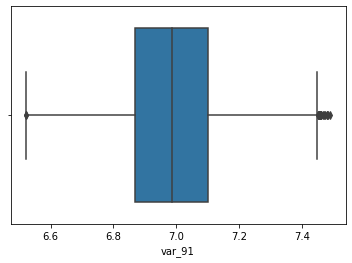

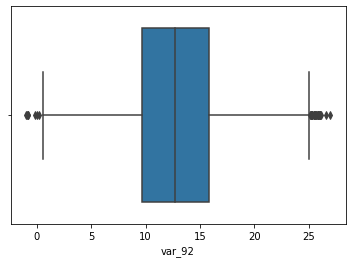

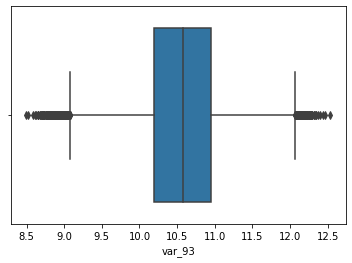

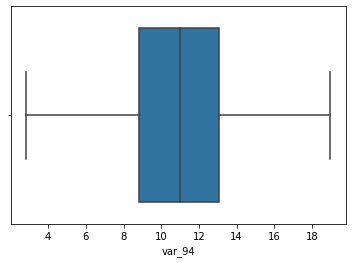

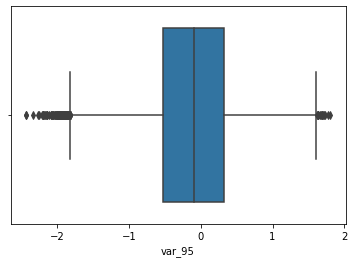

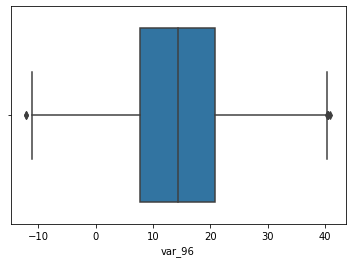

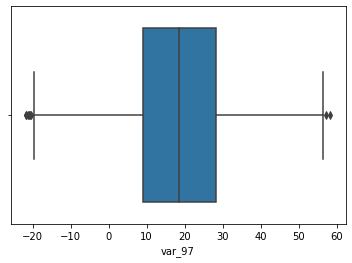

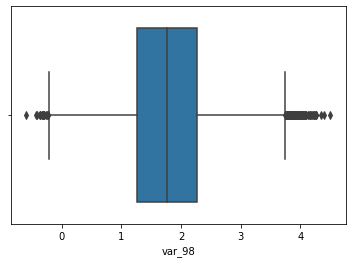

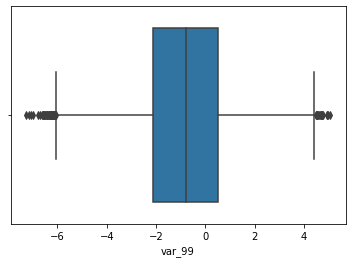

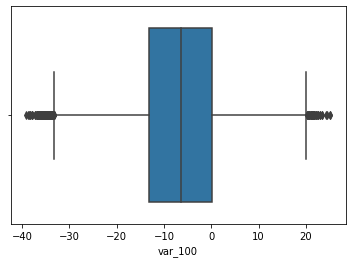

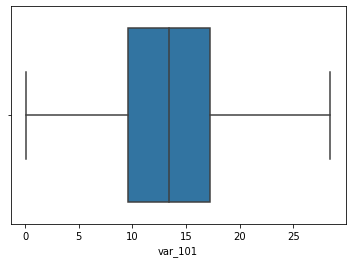

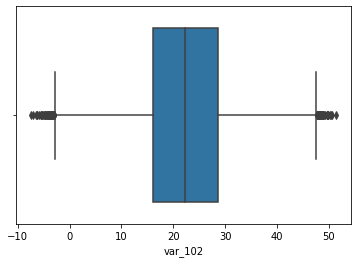

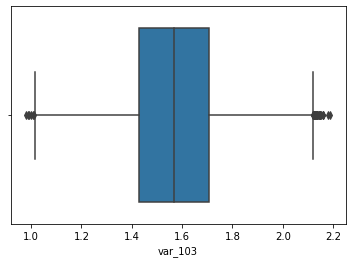

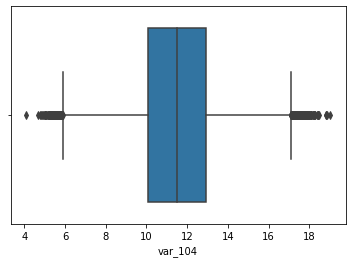

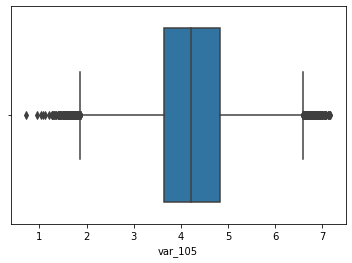

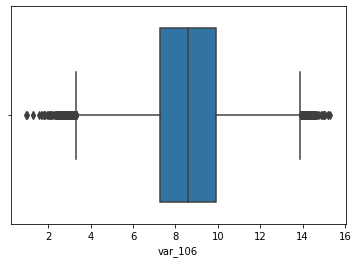

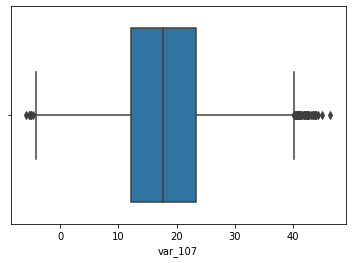

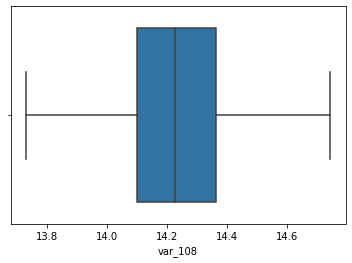

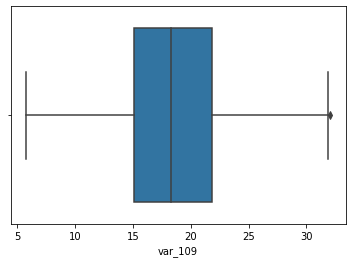

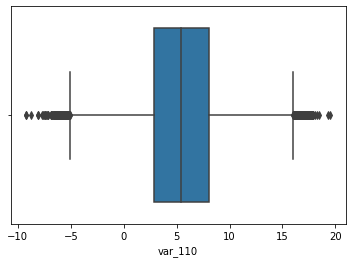

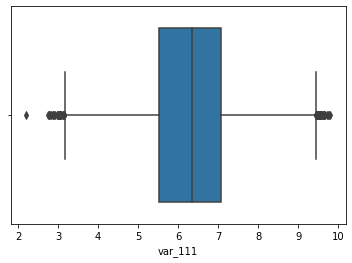

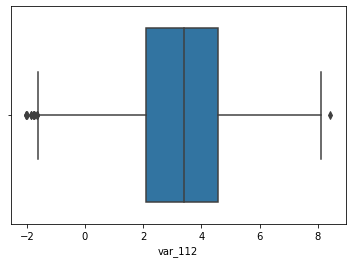

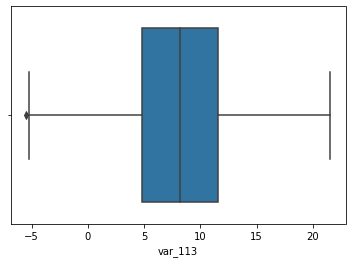

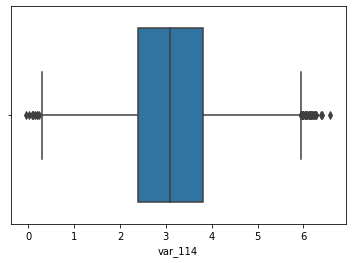

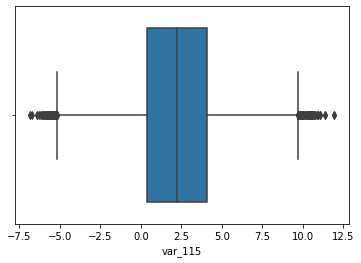

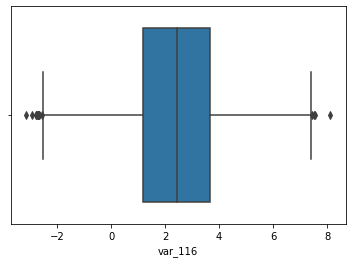

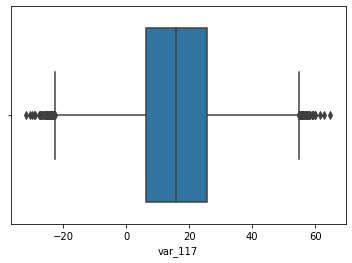

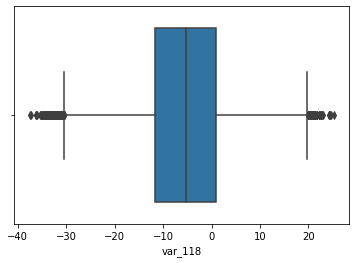

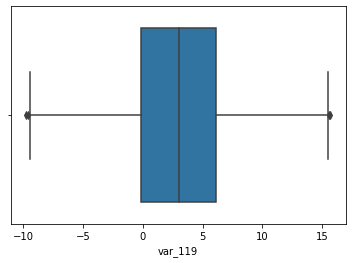

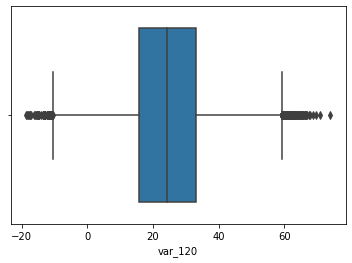

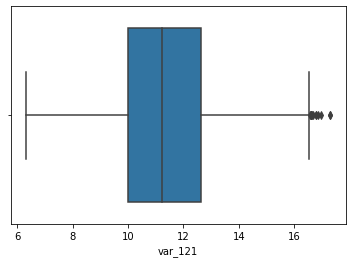

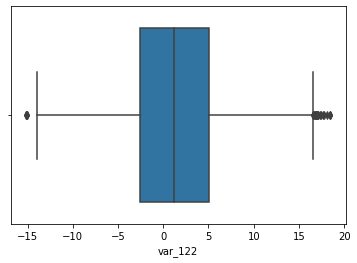

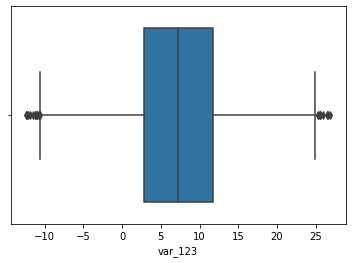

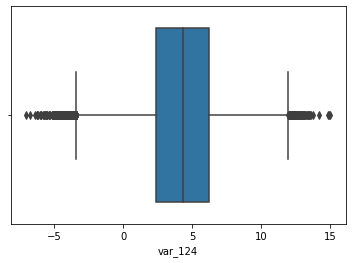

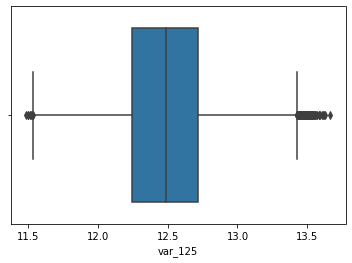

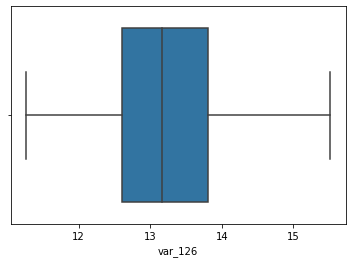

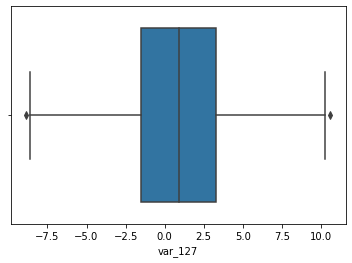

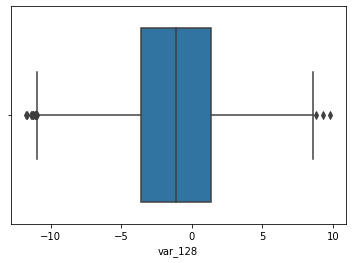

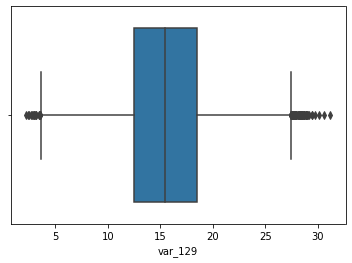

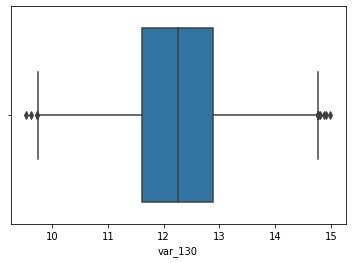

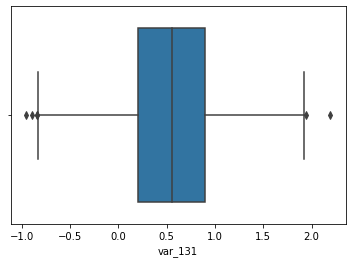

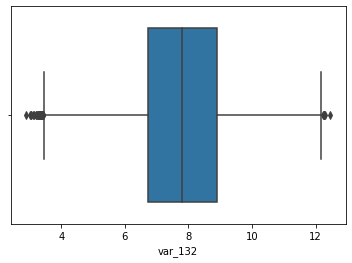

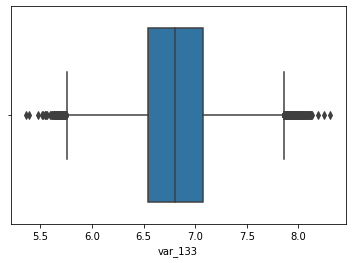

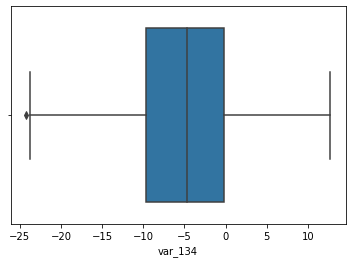

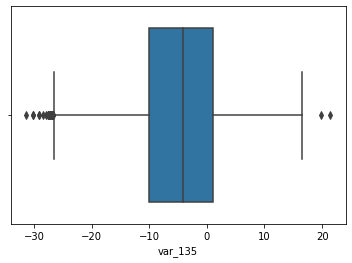

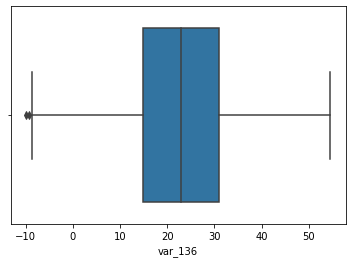

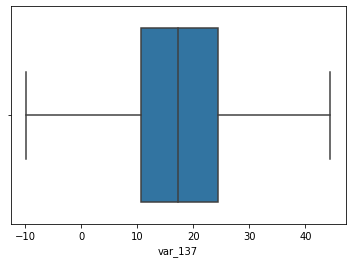

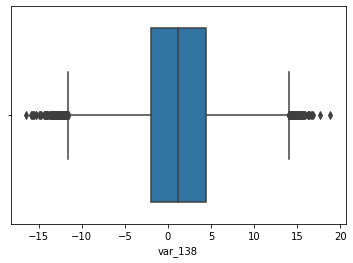

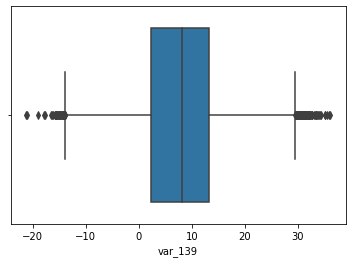

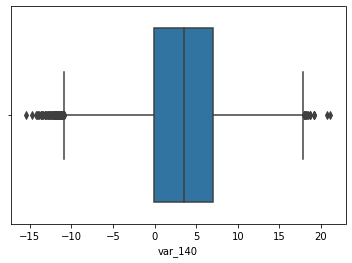

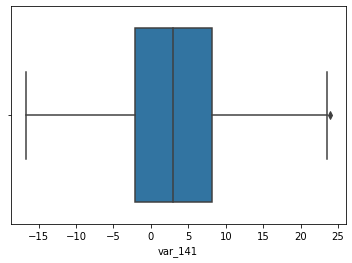

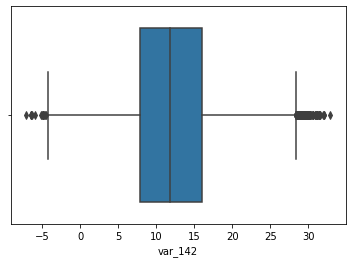

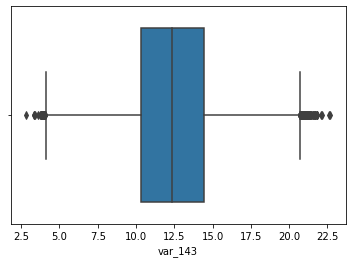

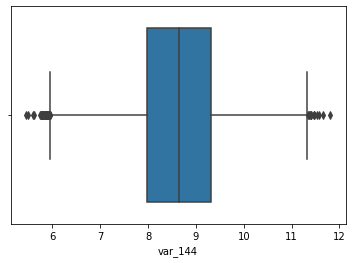

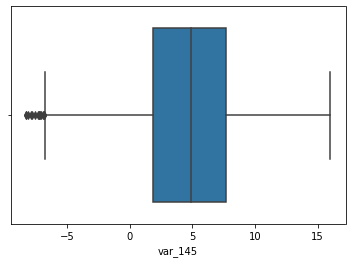

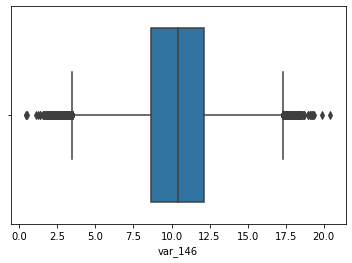

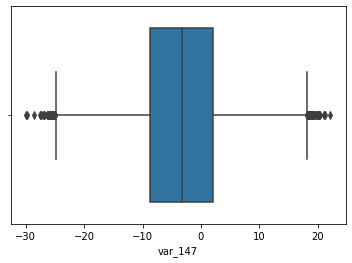

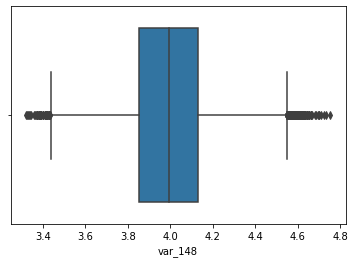

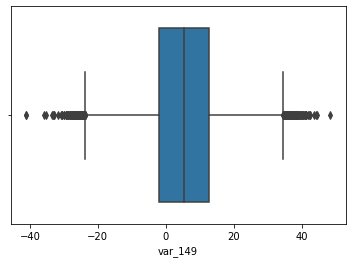

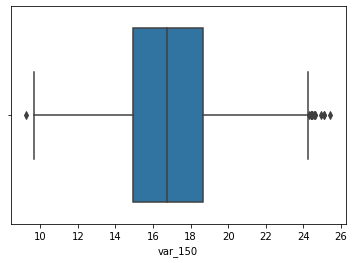

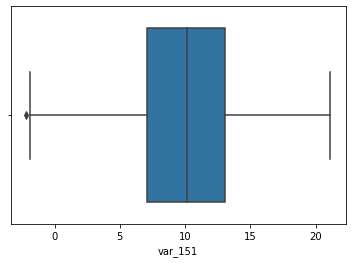

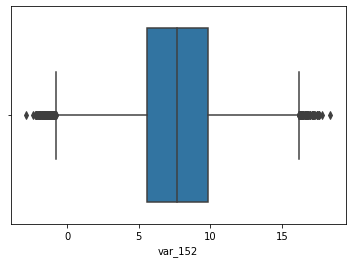

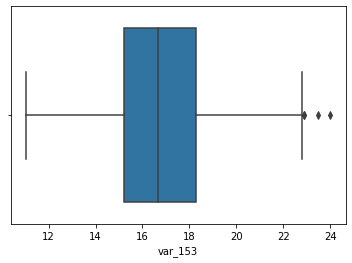

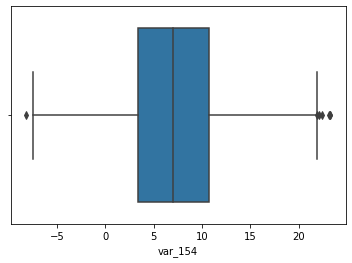

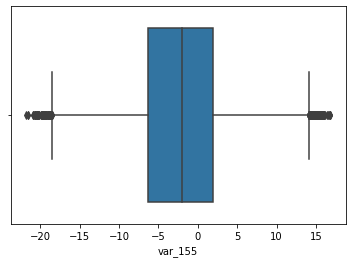

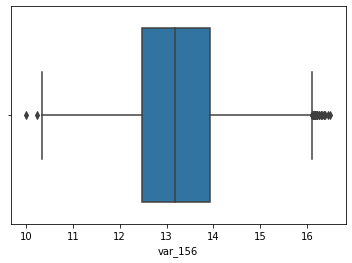

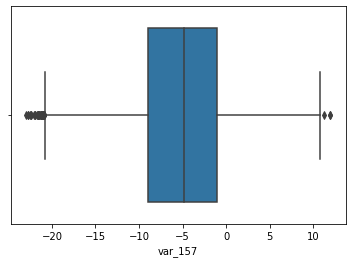

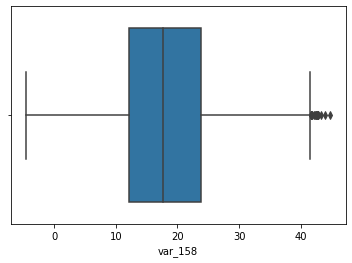

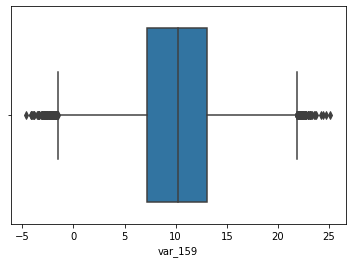

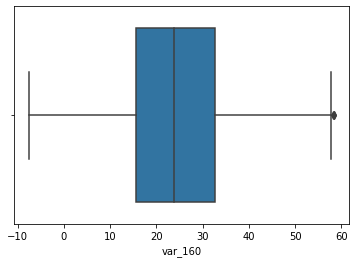

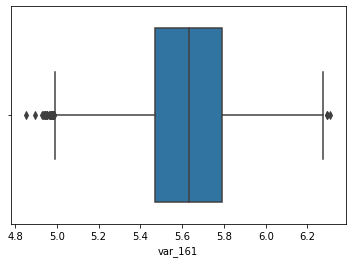

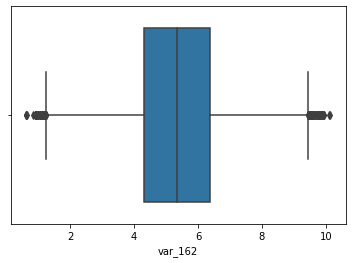

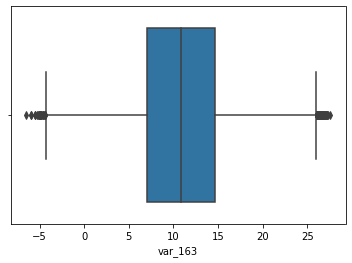

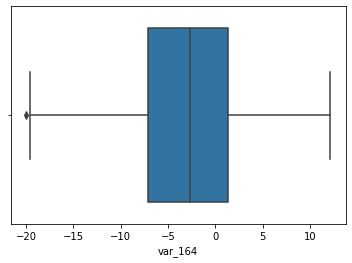

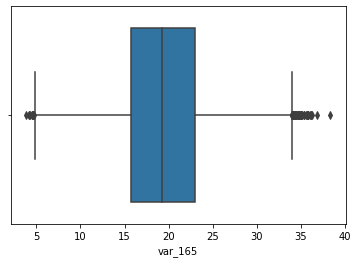

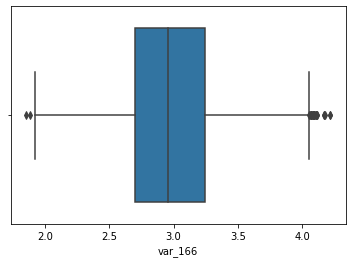

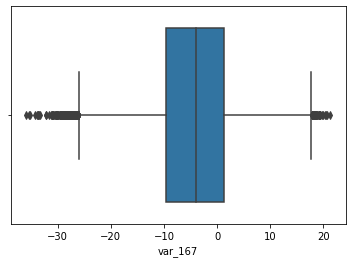

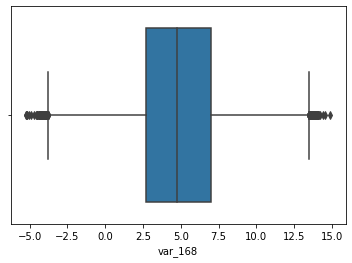

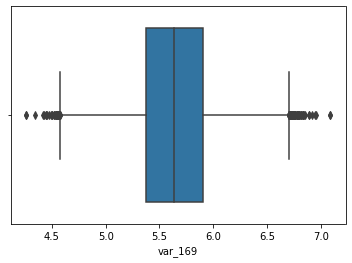

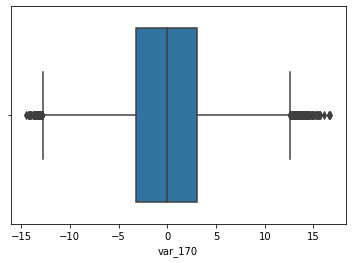

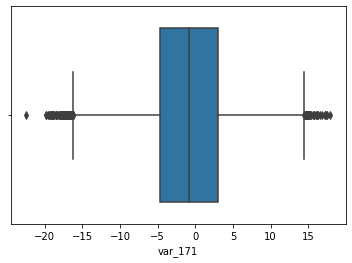

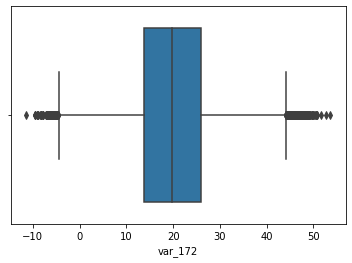

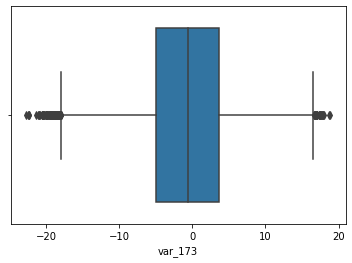

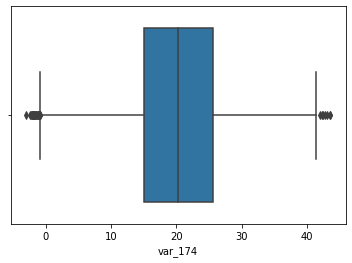

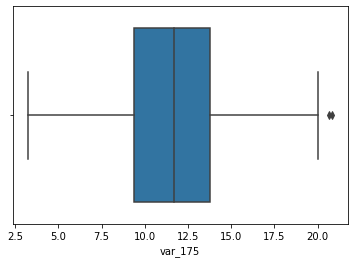

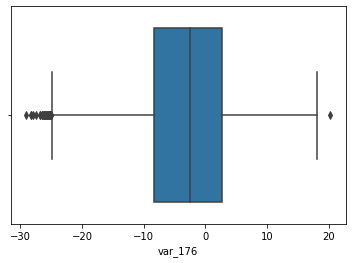

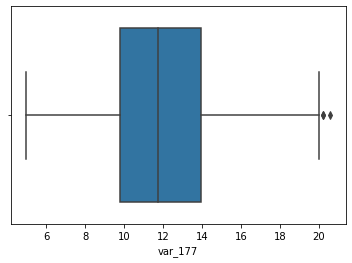

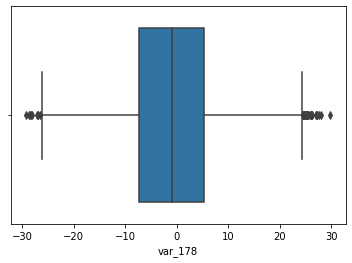

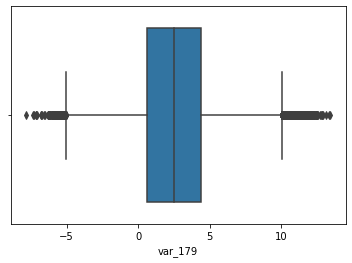

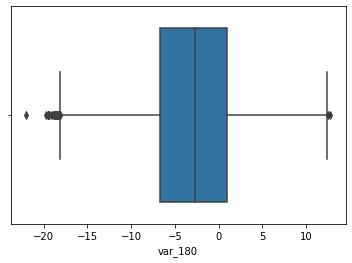

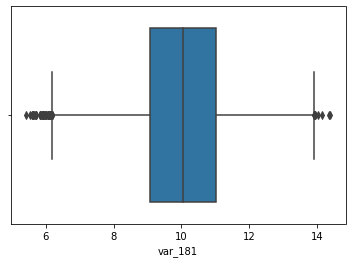

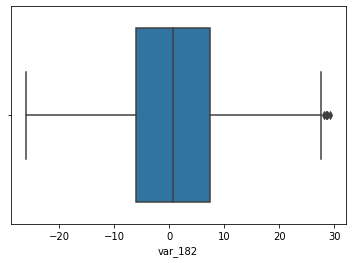

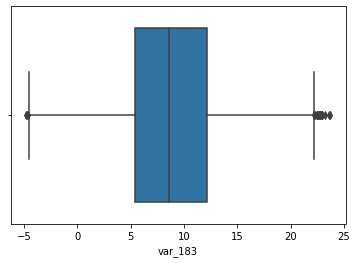

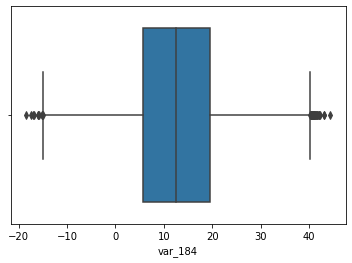

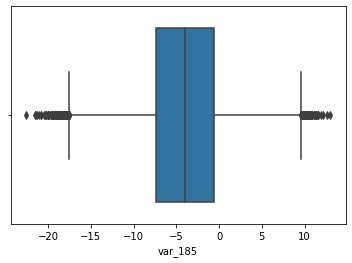

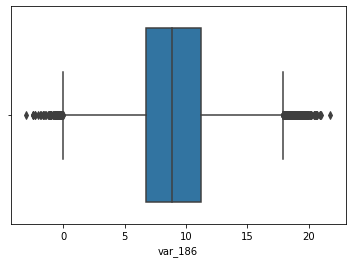

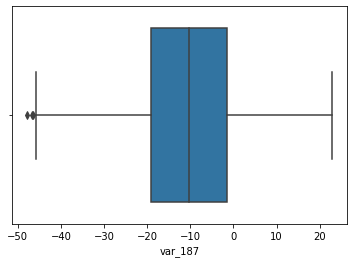

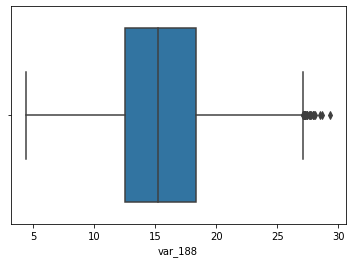

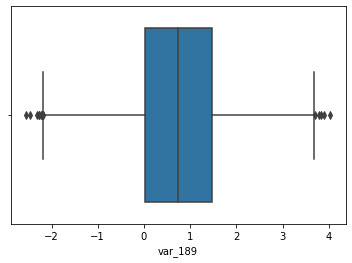

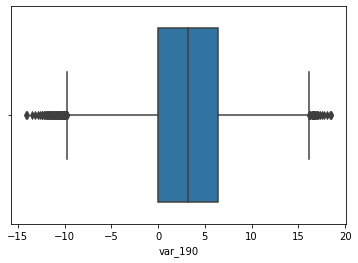

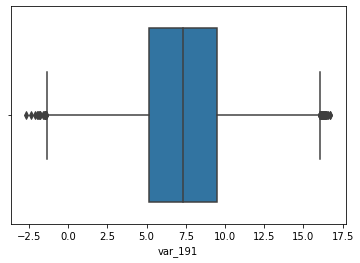

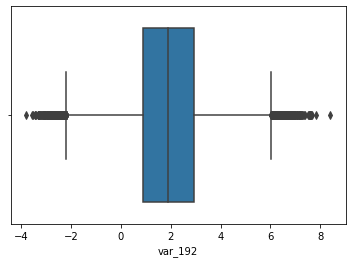

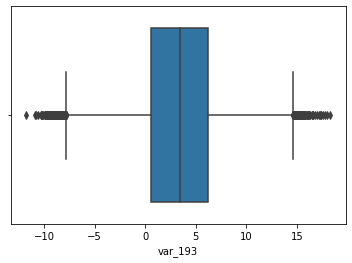

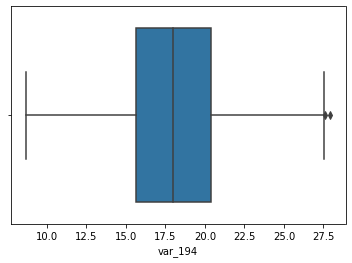

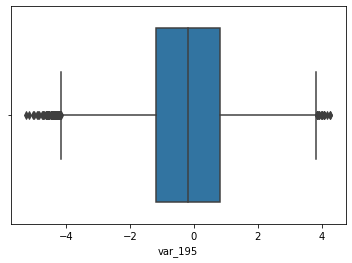

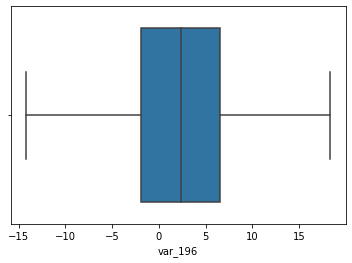

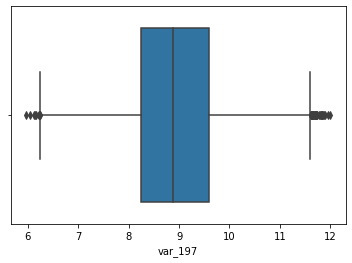

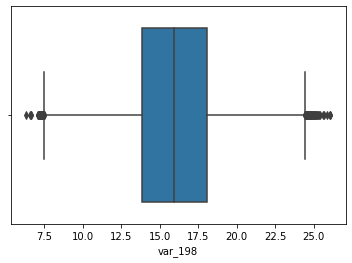

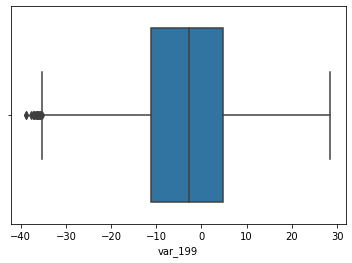

In [0]:
for i in range(2,len(data.columns)):
  sns.boxplot(x=data[data.columns[i]])
  plt.show()

Using boxplot we can know the outliers. In the above pictures box plot is showing few points are outliers but those points are not wide away from the whiskers.Those are within the range of 2-5 units. So we dont consider as outliers.

In [0]:
train_attr=data.columns[2:]
test_attr=final_test.columns[1:]

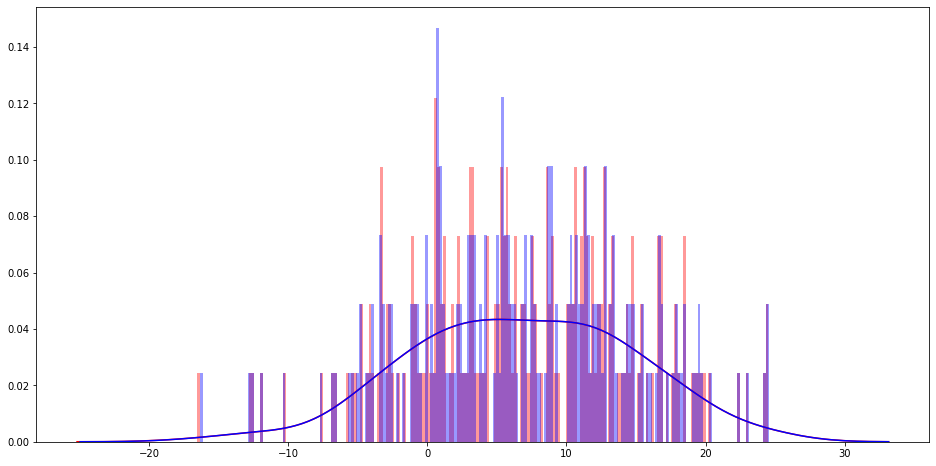

In [0]:
plt.figure(figsize=(16,8))
#Distribution plot for mean values per column in train attributes
sns.distplot(data[train_attr].mean(axis=0),color='red',kde=True,bins=200,label='train')
#Distribution plot for mean values per column in test attributes
sns.distplot(final_test[test_attr].mean(axis=0),color='blue',kde=True,bins=200,label='test')
plt.show()

#Dealing of imbalanced data

In [0]:
class_0=data[data['target']==0]
class_1=data[data['target']==1]
class_1=resample(class_1,n_samples=len(class_0),replace=True)
data=pd.concat([class_0,class_1])

Now the class 0 and class 1 have same count

In [0]:
data.shape

(359804, 202)

In [0]:
data['target'].value_counts()

1    179902
0    179902
Name: target, dtype: int64

# Model Training

In [0]:
X_train,X_test,Y_train,Y_test=train_test_split(data.iloc[:,2:],data.iloc[:,1],test_size=0.2)

In [0]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(287843, 200)
(287843,)
(71961, 200)
(71961,)


# Logistic Regression

In [0]:
LR=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=20000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LR.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=20000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
Y_pre=LR.predict(X_train)
print(pd.crosstab(Y_train,Y_pre))
print(roc_auc_score(Y_train,Y_pre))

col_0        0       1
target                
0       112545   31430
1        31738  112130
0.7805466062340827


# Decision Tree Classifier

In [0]:
DTC=DecisionTreeClassifier(criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
DTC.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
Y_pre=DTC.predict(X_train)
print(pd.crosstab(Y_train,Y_pre))
print(roc_auc_score(Y_train,Y_pre))

col_0        0       1
target                
0       143975       0
1            0  143868
1.0


In [0]:
Y_pre=DTC.predict(X_test)
print(pd.crosstab(Y_test,Y_pre))
print(roc_auc_score(Y_test,Y_pre))

col_0       0      1
target              
0       31650   4277
1          16  36018
0.9402545092922364


In decision tree the test accuracy is more difference than train accuracy. It seems like it was overfitting.

# Random Forest 

In [0]:
rfc=RandomForestClassifier(criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100)
rfc.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
Y_pre=rfc.predict(X_train)
print(pd.crosstab(Y_train,Y_pre))
print(roc_auc_score(Y_train,Y_pre))

col_0        0       1
target                
0       143975       0
1            0  143868
1.0


In [0]:
Y_pre=rfc.predict(X_test)
print(pd.crosstab(Y_test,Y_pre))
print(roc_auc_score(Y_test,Y_pre))

col_0       0      1
target              
0       35927      0
1          16  36018
0.9997779874562913


Random Forest has great test accuracy than Decision tree

# Gradient Boosting

In [0]:
gbm=GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=7, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=2, max_leaf_nodes=None, warm_start=False, presort='deprecated', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

In [0]:
gbm.fit(X_train,Y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3657           99.97m
         2           1.3474           97.84m
         3           1.3310           96.44m
         4           1.3163           95.61m
         5           1.3019           94.28m
         6           1.2889           93.34m
         7           1.2759           92.54m
         8           1.2633           91.41m
         9           1.2509           90.29m
        10           1.2382           89.26m
        11           1.2267           88.33m
        12           1.2159           87.49m
        13           1.2053           86.47m
        14           1.1943           85.68m
        15           1.1844           84.56m
        16           1.1754           83.45m
        17           1.1653           82.42m
        18           1.1558           81.49m
        19           1.1469           80.58m
        20           1.1386           79.57m
        21           1.1301           78.49m
        2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=7,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

In [0]:
Y_pre=gbm.predict(X_train)
print(pd.crosstab(Y_train,Y_pre))
print(roc_auc_score(Y_train,Y_pre))

col_0        0       1
target                
0       133051   10908
1        14618  129266
0.9113163481277933


# LGBM

In [0]:
#Training data
lgb_train=lgb.Dataset(X_train,label=Y_train)

#Validation data
lgb_valid=lgb.Dataset(X_test,label=Y_test)

In [0]:
params={'boosting_type': 'gbdt', 
          'max_depth' : -1, 
          'objective': 'binary',
          'boost_from_average':False, 
          'nthread': 20,
          'metric':'auc',
          'num_leaves': 50,
          'learning_rate': 0.01,
          'max_bin': 100,     
          'subsample_for_bin': 100,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'bagging_fraction':0.5,
          'bagging_freq':5,
          'feature_fraction':0.08,
          'min_split_gain': 0.45,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'is_unbalance':True,
          }

In [0]:
num_rounds=20000
lgbm= lgb.train(params,lgb_train,num_rounds,valid_sets=[lgb_train,lgb_valid],verbose_eval=1000,early_stopping_rounds = 5000)
lgbm

Training until validation scores don't improve for 5000 rounds.
[1000]	training's auc: 0.934356	valid_1's auc: 0.925149
[2000]	training's auc: 0.953742	valid_1's auc: 0.942497
[3000]	training's auc: 0.967233	valid_1's auc: 0.954778
[4000]	training's auc: 0.976997	valid_1's auc: 0.964127
[5000]	training's auc: 0.984056	valid_1's auc: 0.971364
[6000]	training's auc: 0.989216	valid_1's auc: 0.977001
[7000]	training's auc: 0.992861	valid_1's auc: 0.981347
[8000]	training's auc: 0.995416	valid_1's auc: 0.984781
[9000]	training's auc: 0.997159	valid_1's auc: 0.987501
[10000]	training's auc: 0.998291	valid_1's auc: 0.989656
[11000]	training's auc: 0.999014	valid_1's auc: 0.991384
[12000]	training's auc: 0.999444	valid_1's auc: 0.992744
[13000]	training's auc: 0.999692	valid_1's auc: 0.993841
[14000]	training's auc: 0.999832	valid_1's auc: 0.994729
[15000]	training's auc: 0.999905	valid_1's auc: 0.995448
[16000]	training's auc: 0.999945	valid_1's auc: 0.996024
[17000]	training's auc: 0.999967	

In [0]:

#probability predictions
lgbm_predict_prob=lgbm.predict(X_test,random_state=42,num_iteration=lgbm.best_iteration)

#Convert to binary output 1 or 0
lgbm_predict=np.where(lgbm_predict_prob>=0.5,1,0)
print(lgbm_predict_prob)
print(lgbm_predict)

[0.03553894 0.18682337 0.87614567 ... 0.89156001 0.95011306 0.06249369]
[0 0 1 ... 1 1 0]


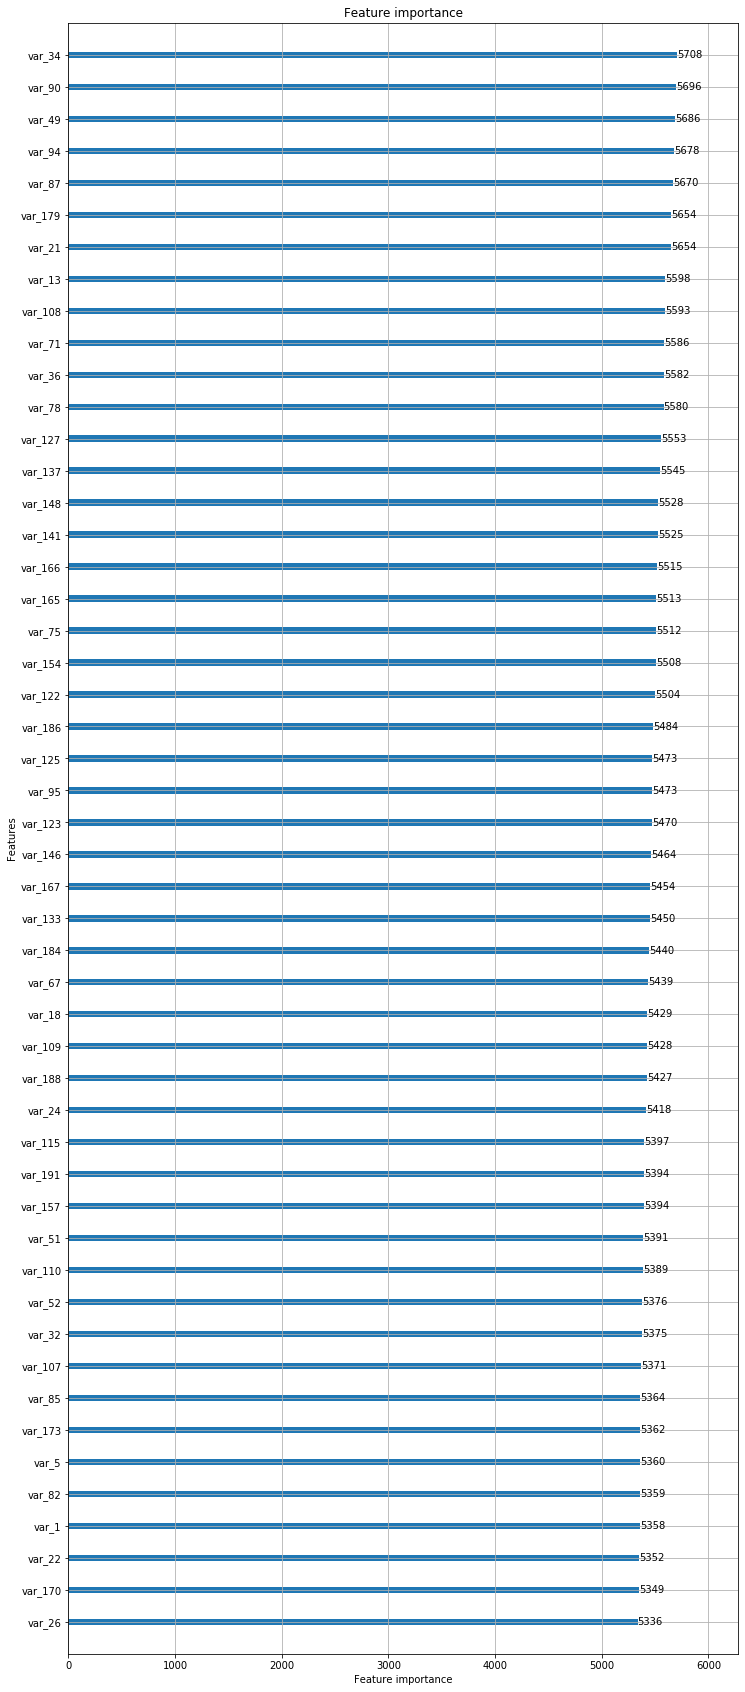

In [0]:
lgb.plot_importance(lgbm,max_num_features=50,importance_type="split",figsize=(12,30))

# Model Evaluation

From Logistic regression, Decision Tree, Random Forest the best model is LGBM.




In [0]:
data.shape

(359804, 202)

In [0]:
data.head()

ID_code  target    var_0   var_1  ...  var_196  var_197  var_198  var_199
0  train_0       0   8.9255 -6.7863  ...   7.8784   8.5635  12.7803  -1.0914
1  train_1       0  11.5006 -4.1473  ...   8.1267   8.7889  18.3560   1.9518
2  train_2       0   8.6093 -2.7457  ...  -6.5213   8.2675  14.7222   0.3965
3  train_3       0  11.0604 -2.1518  ...  -2.9275  10.2922  17.9697  -8.9996
4  train_4       0   9.8369 -1.4834  ...   3.9267   9.5031  17.9974  -8.8104

[5 rows x 202 columns]

In [0]:
final_test.head()

ID_code    var_0    var_1    var_2  ...  var_196  var_197  var_198  var_199
0  test_0  11.0656   7.7798  12.9536  ...   4.3654  10.7200  15.4722  -8.7197
1  test_1   8.5304   1.2543  11.3047  ...  -1.4852   9.8714  19.1293 -20.9760
2  test_2   5.4827 -10.3581  10.1407  ...  -7.1086   7.0618  19.8956 -23.1794
3  test_3   8.5374  -1.3222  12.0220  ...   3.9567   9.2295  13.0168  -4.2108
4  test_4  11.7058  -0.1327  14.1295  ...  -5.1612   7.2882  13.9260  -9.1846

[5 rows x 201 columns]

In [0]:
#probability predictions
lgbm_predict_prob=lgbm.predict(final_test.iloc[:,1:],random_state=39,num_iteration=lgbm.best_iteration)

#Convert to binary output 1 or 0
lgbm_predict=np.where(lgbm_predict_prob>=0.5,1,0)
print(lgbm_predict_prob)
print(lgbm_predict)

[0.10762405 0.49294122 0.1731895  ... 0.00244286 0.25619263 0.12571535]
[0 0 0 ... 0 0 0]


In [0]:
fin=pd.DataFrame({'ID_code':final_test['ID_code'].values})

In [0]:
fin['target']=lgbm_predict
fin.to_csv('fsubmission.csv',index=False)

In [0]:
fin.head()

ID_code  target
0  test_0       0
1  test_1       0
2  test_2       0
3  test_3       0
4  test_4       0